In [1]:
import os
import pandas as pd
from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle

# from my_modules
import feature_extraction
import algorithms
import evaluate_performance

In [2]:
# set wd
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis")

# **MFCCs**

## **Data Preparation** (MFCCs)

In [3]:
# import the data
train = pd.read_csv("code/general_identification/datasets/audio_training_bal.csv", index_col=0)
test = pd.read_csv("code/general_identification/datasets/testing_audio.csv", index_col=0)

In [4]:
print(train.shape)
train.head()

(221490, 12)


GroupName Sex  AgeDays  AgeYears     RecDate  \
index                                                
41       Baobab   F      948  2.597260  17/09/2014   
65       Baobab   F      948  2.597260  17/09/2014   
58       Baobab   F      948  2.597260  17/09/2014   
121      Baobab   F      884  2.421918  15/07/2014   
26       Baobab   F      948  2.597260  17/09/2014   

                           SourceFile     Code    ID  \
index                                                  
41     VBBF083_BB_2_AM_17SEPT2014.WAV  VBBF083  2741   
65     VBBF083_BB_2_AM_17SEPT2014.WAV  VBBF083  2741   
58     VBBF083_BB_2_AM_17SEPT2014.WAV  VBBF083  2741   
121       VBBF083_BB_2_15July2014.WAV  VBBF083  2741   
26     VBBF083_BB_1_AM_17SEPT2014.WAV  VBBF083  2741   

                                   CallFile CallTime CallType  \
index                                                           
41     VBBF083_BB_2_AM_17SEPT2014_AD_01.WAV  00:34.3       SC   
65     VBBF083_BB_2_AM_17SEPT2014_AD_28.WAV  07:23.0       SC   
58     VBBF083_BB_2_AM_17SEPT2014_AD_20.WAV  05:04.6       SC   
121       VBBF083_BB_2_15July2014_AD_30.WAV  04:26.5       FO   
26     VBBF083_BB_1_AM_17SEPT2014_AD_29.WAV  02:38.4       SC   

                                                    Path  
index                                                     
41     audio\raw_cut\VBBF083\VBBF083_BB_2_AM_17SEPT20...  
65     audio\raw_cut\VBBF083\VBBF083_BB_2_AM_17SEPT20...  
58     audio\raw_cut\VBBF083\VBBF083_BB_2_AM_17SEPT20...  
121    audio\raw_cut\VBBF083\VBBF083_BB_2_15July2014_...  
26     audio\raw_cut\VBBF083\VBBF083_BB_1_AM_17SEPT20...

In [5]:
print(test.shape)
test.head()

(522, 12)


GroupName Sex  AgeDays  AgeYears     RecDate  \
index                                                
8        Baobab   F      883  2.419178  14/07/2014   
19       Baobab   F      941  2.578082  10/09/2014   
2        Baobab   F      883  2.419178  14/07/2014   
26       Baobab   F      941  2.578082  10/09/2014   
22       Baobab   F      941  2.578082  10/09/2014   

                           SourceFile     Code    ID  \
index                                                  
8      VBBF083_BB_1_PM_14July2014.WAV  VBBF083  2741   
19     VBBF083_BB_1_PM_10SEPT2014.WAV  VBBF083  2741   
2      VBBF083_BB_1_PM_14July2014.WAV  VBBF083  2741   
26     VBBF083_BB_1_PM_10SEPT2014.WAV  VBBF083  2741   
22     VBBF083_BB_1_PM_10SEPT2014.WAV  VBBF083  2741   

                                   CallFile CallTime CallType  \
index                                                           
8      VBBF083_BB_1_PM_14July2014_AD_09.WAV  01:29.3       SC   
19     VBBF083_BB_1_PM_10SEPT2014_AD_02.WAV  00:48.4       SC   
2      VBBF083_BB_1_PM_14July2014_AD_03.WAV  00:50.5       SC   
26     VBBF083_BB_1_PM_10SEPT2014_AD_14.WAV  09:59.3       FO   
22     VBBF083_BB_1_PM_10SEPT2014_AD_05.WAV  02:16.9       SC   

                                                    Path  
index                                                     
8      audio\raw_cut\VBBF083\VBBF083_BB_1_PM_14July20...  
19     audio\raw_cut\VBBF083\VBBF083_BB_1_PM_10SEPT20...  
2      audio\raw_cut\VBBF083\VBBF083_BB_1_PM_14July20...  
26     audio\raw_cut\VBBF083\VBBF083_BB_1_PM_10SEPT20...  
22     audio\raw_cut\VBBF083\VBBF083_BB_1_PM_10SEPT20...

In [6]:
# random sorting 
train = train.sample(frac=1, ignore_index=True, random_state=33).reset_index()
test = test.sample(frac=1, ignore_index=True, random_state=33).reset_index()

### Data Distribution:

In [7]:
print("N_training: {0}\nN_testing: {1}".format(train.shape[0], test.shape[0]))
train.groupby(["Code"]).size()

N_training: 221490
N_testing: 522


Code
VBBF083    12305
VBBF088    12305
VBBM071    12305
VBBM090    12305
VRRF180    12305
VRRM181    12305
VRRM182    12305
VRRM183    12305
VUKF016    12305
VUKF018    12305
VUKM004    12305
VUKM017    12305
VVHM089    12305
VWM132     12305
VZUF009    12305
VZUF014    12305
VZUM011    12305
VZUM016    12305
dtype: int64

In [8]:
# random selections for train-test-split
np.random.seed(32)
idxs_train = [train.groupby("Code").sample(n=train.groupby(["Code"]).size().min()//10, random_state=np.random.randint(0, 100)).index.to_list() for i in range(10)]
idxs_test = [test.groupby("Code").sample(n=test.groupby(["Code"]).size().min()//10, random_state=np.random.randint(0, 100)).index.to_list() for i in range(10)]

### Feature Extraction (MFCCs)

In [9]:
# load the audio signals
train_sig, train_sr = feature_extraction.audio(train["Path"].to_list())
test_sig, test_sr = feature_extraction.audio(test["Path"].to_list())
len(train_sig) == train.shape[0]

C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


True

In [10]:
# define the targets
y_train, _ = feature_extraction.get_targets(metadata_df=train, show_distribution=False)
y_test, individuals_test = feature_extraction.get_targets(metadata_df=test, show_distribution=False)

In [11]:
# set results wd
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/code/general_identification")

## **Baseline Dummy classifier (using stratified startegy):**

In [12]:
# dummy classifier
pred_dummy = [] # predicted list
probs_dummy = [] # predicted probabilities list
ytrues = [] # list of true labels

dummy_times = [] # time elapsed list

# train and test 10 times on different subsets of data
for i in range(10):
    
    # feature extraction
    X_train, _ = feature_extraction.features(
    signals=train_sig[idxs_train[i]], sample_rates=train_sr[idxs_train[i]]
    )
    X_test, _ = feature_extraction.features(
        signals=test_sig[idxs_test[i]], sample_rates=test_sr[idxs_test[i]]
    )

    # flatten the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

    # training
    start = time.perf_counter()

    dummy = algorithms.Dummy(random_state=i+33)
    dummy.fit(X=X_train, y=y_train[idxs_train[i]])

    end = time.perf_counter()

    # model evaluation
    tmp_pred, tmp_prob = dummy.predict(X=X_test)

    pred_dummy.append(tmp_pred)
    probs_dummy.append(tmp_prob)
    ytrues.append(y_test[idxs_test[i]])

    dummy_times.append(end-start)

# to arrays
pred_dummy = np.array(pred_dummy)
probs_dummy = np.array(probs_dummy)
ytrues = np.array(ytrues)

# reshaping the arrays to the correct shape (as if it was all one test)
pred_dummy = np.reshape(pred_dummy, newshape=(pred_dummy.shape[1]*10))
probs_dummy = np.reshape(probs_dummy, 
    newshape=(probs_dummy.shape[1]*10, probs_dummy.shape[2]))
ytrues = np.reshape(ytrues, newshape=(ytrues.shape[1]*10))

In [13]:
# save variables
d = {
    "times": dummy_times,
    "pred": pred_dummy,
    "probs": probs_dummy,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_mfccs/dummy/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Dummy metrics

Confusion Matrix

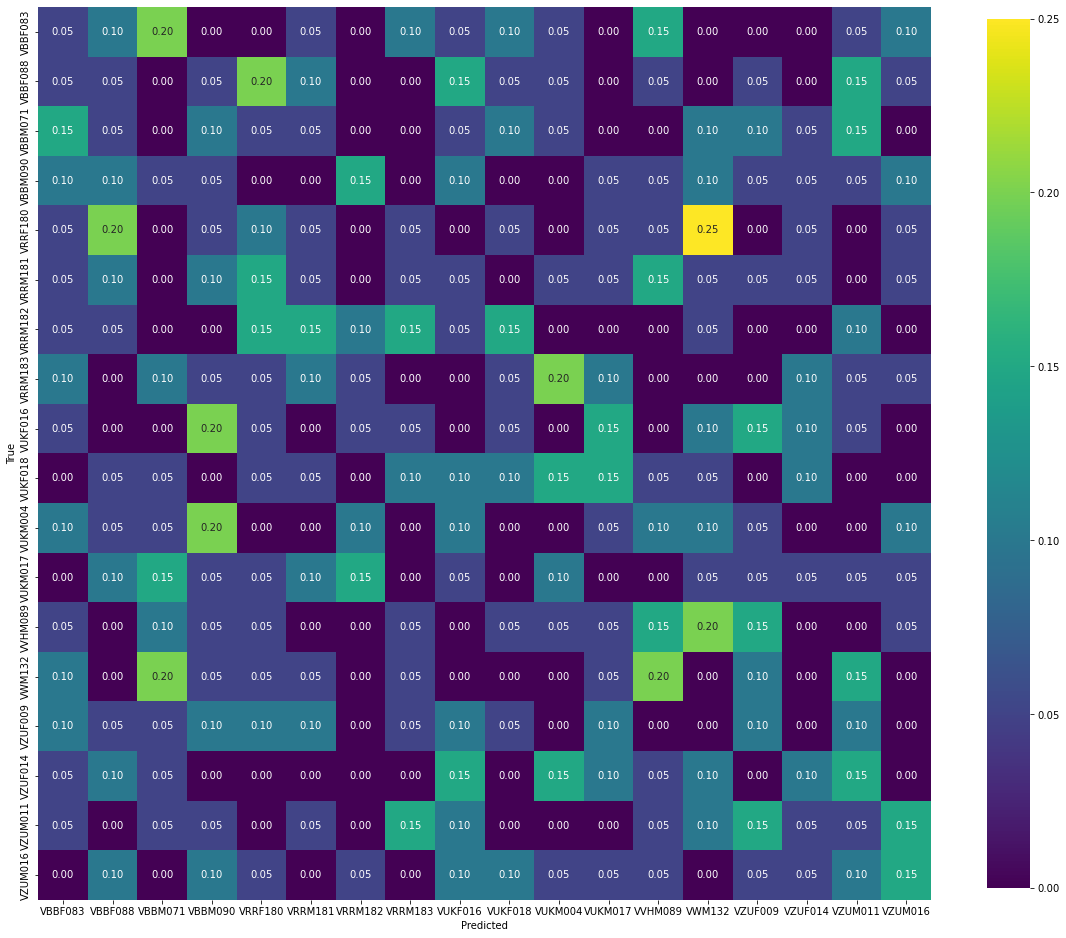

In [14]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_dummy, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_dummy, labels=individuals_test, ax=ax 
)
fig.savefig("results_mfccs/dummy/cf_dummy.png")

In [15]:
mcc_dummy = evaluate_performance.matthews(y=ytrues, yp=pred_dummy)
kappa_dummy = evaluate_performance.cohen(y=ytrues, yp=pred_dummy)

ROC curve and AUC score

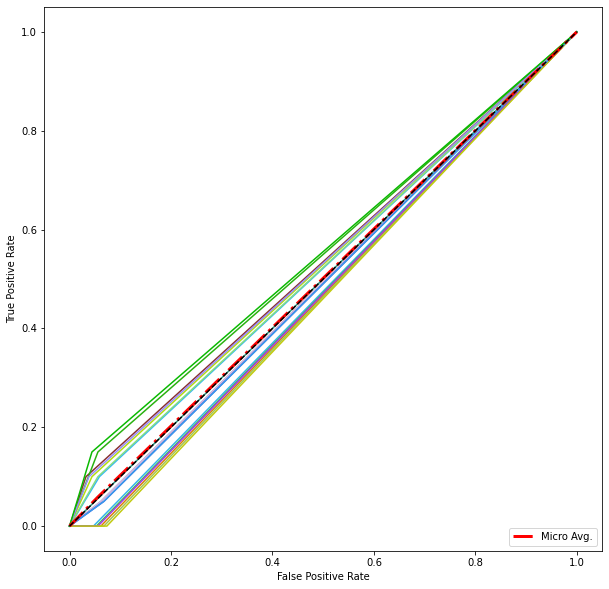

AUC score: 0.501


In [16]:
# dummy classifier metrics
fig, ax = plt.subplots(1,1, figsize=(10,10))

auc_dummy, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
     y_score=probs_dummy, n_classes=len(np.unique(individuals_test)),
     ax=ax
    )
fig.savefig("results_mfccs/dummy/roc_dummy.png")

print("AUC score: {:0.3f}".format(auc_dummy))

Metrics

In [17]:
metr_dummy, acc_dummy, f1_dummy = evaluate_performance.metrics(
    y=ytrues, yp=pred_dummy,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_dummy, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)

# save metrics
d = {
    "acc": acc_dummy,
    "auc": auc_dummy,
    "f1": f1_dummy,
    "mcc": mcc_dummy,
    "kappa": kappa_dummy,
    "table": metr_dummy
}
with open("results_mfccs/dummy/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

print("Macro avg. Accuracy: {:0.3f}".format(acc_dummy))
metr_dummy

Macro avg. Accuracy: 0.058


Label  Precision    Recall
0      VBBF083   0.045455  0.050000
1      VBBF088   0.045455  0.050000
2      VBBM071   0.000000  0.000000
3      VBBM090   0.041667  0.050000
4      VRRF180   0.090909  0.100000
5      VRRM181   0.055556  0.050000
6      VRRM182   0.153846  0.100000
7      VRRM183   0.000000  0.000000
8      VUKF016   0.000000  0.000000
9      VUKF018   0.117647  0.100000
10     VUKM004   0.000000  0.000000
11     VUKM017   0.000000  0.000000
12     VVHM089   0.136364  0.150000
13      VWM132   0.000000  0.000000
14     VZUF009   0.095238  0.100000
15     VZUF014   0.133333  0.100000
16     VZUM011   0.041667  0.050000
17     VZUM016   0.166667  0.150000
18  Macro Avg.   0.062433  0.058333

## **K-Means clustering classifier:**

In [18]:
# k-means
pred_km = []
probs_km = []

times_km = []

for i in range(10):

    # feature extraction
    X_train, _ = feature_extraction.features(
    signals=train_sig[idxs_train[i]], sample_rates=train_sr[idxs_train[i]]
    )
    X_test, _ = feature_extraction.features(
        signals=test_sig[idxs_test[i]], sample_rates=test_sr[idxs_test[i]]
    )

    # flatten the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
    
    # training
    start = time.perf_counter()
    
    km = algorithms.Kmeans(n_classes=len(train.Code.unique()), random_state=i+53, do_umap=False)
    km.fit(X=X_train, y=y_train[idxs_train[i]])

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = km.predict(X=X_test, y_test=y_test[idxs_test[i]])

    pred_km.append(tmp_pred)
    probs_km.append(tmp_prob)

    times_km.append(end-start)

# to arrays
pred_km = np.array(pred_km)
probs_km = np.array(probs_km)

# reshaping
pred_km = np.reshape(pred_km, newshape=(pred_km.shape[1]*10))
probs_km = np.reshape(probs_km, 
    newshape=(probs_km.shape[1]*10, probs_km.shape[2]))

In [19]:
# save model
km.save("models/kmeans/km_mfcc.pkl")

In [20]:
# save variables
d = {
    "times": times_km,
    "pred": pred_km,
    "probs": probs_km,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_mfccs/kmeans/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### K-means metrics

Confusion Matrix

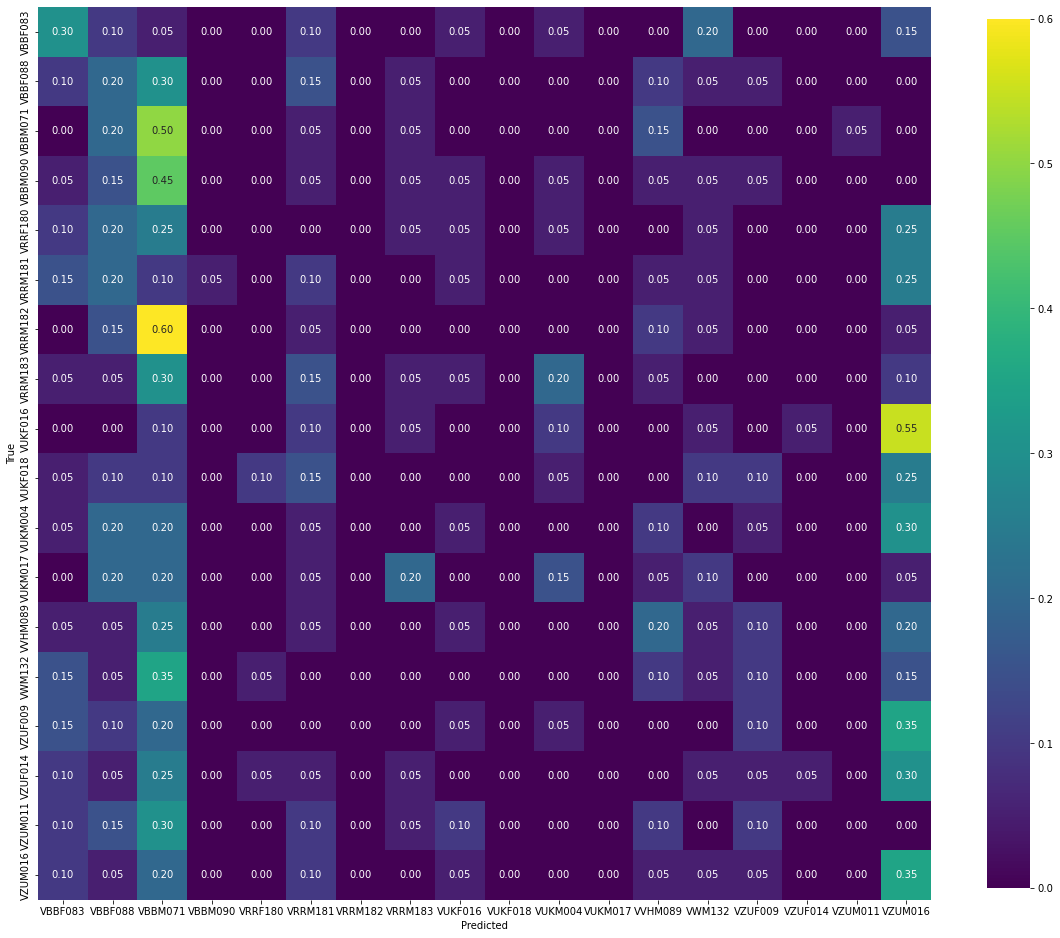

In [21]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_km, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_km, labels=individuals_test, ax=ax
)
fig.savefig("results_mfccs/kmeans/cf_km.png")

In [22]:
mcc_km = evaluate_performance.matthews(y=ytrues, yp=pred_km)
kappa_km = evaluate_performance.cohen(y=ytrues, yp=pred_km)

ROC curve and AUC score

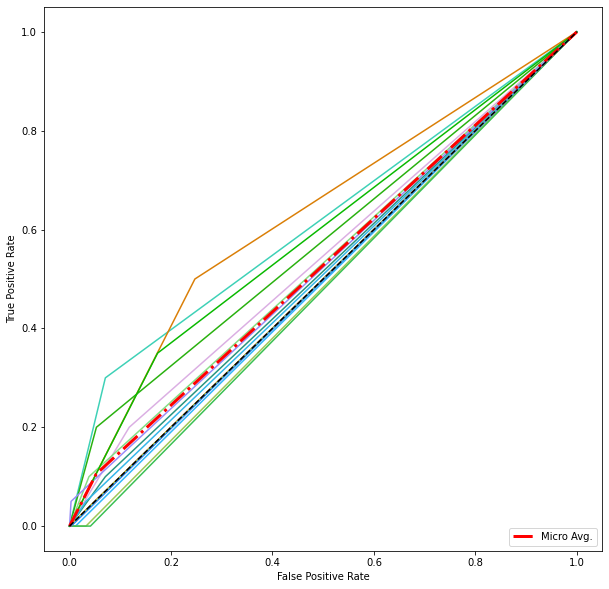

AUC score: 0.526


In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

auc_km, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_km, n_classes=len(individuals_test), ax=ax
)
fig.savefig("results_mfccs/kmeans/roc_km.png")
print("AUC score: {:0.3f}".format(auc_km))

Metrics

In [24]:
metr_km, acc_km, f1_km = evaluate_performance.metrics(
    y=ytrues, yp=pred_km,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_km, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)

print("Macro avg. Accuracy: {:0.3f}".format(acc_km))
metr_km

Macro avg. Accuracy: 0.106


C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn

Label  Precision    Recall
0      VBBF083   0.200000  0.300000
1      VBBF088   0.090909  0.200000
2      VBBM071   0.106383  0.500000
3      VBBM090   0.000000  0.000000
4      VRRF180   0.000000  0.000000
5      VRRM181   0.076923  0.100000
6      VRRM182   0.000000  0.000000
7      VRRM183   0.083333  0.050000
8      VUKF016   0.000000  0.000000
9      VUKF018   0.000000  0.000000
10     VUKM004   0.000000  0.000000
11     VUKM017   0.000000  0.000000
12     VVHM089   0.181818  0.200000
13      VWM132   0.055556  0.050000
14     VZUF009   0.133333  0.100000
15     VZUF014   0.500000  0.050000
16     VZUM011   0.000000  0.000000
17     VZUM016   0.106061  0.350000
18  Macro Avg.   0.085240  0.105556

McNemar's test vs. Dummy

In [25]:
stat_km, p_km, tab_km = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy,
    clf2_pred=pred_km
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_km, p_km))

McNemar's test:
	statistic: 4.655
	p-value: 3.097e-02


In [26]:
# save metrics
d = {
    "acc": acc_km,
    "auc": auc_km,
    "f1": f1_km,
    "mcc": mcc_km,
    "kappa": kappa_km,
    "table": metr_km,
    "mcnemar": [stat_km, p_km]
}
with open("results_mfccs/kmeans/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

## **Multinomial Regression Classifier:**

In [27]:
# multinomial regression
pred_multireg = []
probs_multireg = []

times_multireg = []

for i in range(10):

    # feature extraction
    X_train, _ = feature_extraction.features(
    signals=train_sig[idxs_train[i]], sample_rates=train_sr[idxs_train[i]]
    )
    X_test, _ = feature_extraction.features(
        signals=test_sig[idxs_test[i]], sample_rates=test_sr[idxs_test[i]]
    )

    # flatten the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
    
    # training
    start = time.perf_counter()
    
    multireg = algorithms.MultinomReg(random_state=i+42, do_umap=True, n_components=45)
    multireg.fit(X=X_train, y=y_train[idxs_train[i]])

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = multireg.predict(X=X_test)

    pred_multireg.append(tmp_pred)
    probs_multireg.append(tmp_prob)

    times_multireg.append(end-start)

# to arrays
pred_multireg = np.array(pred_multireg)
probs_multireg = np.array(probs_multireg)

# reshaping
pred_multireg = np.reshape(pred_multireg, newshape=(pred_multireg.shape[1]*10))
probs_multireg = np.reshape(probs_multireg, 
    newshape=(probs_multireg.shape[1]*10, probs_multireg.shape[2]))

In [28]:
# save model
multireg.save("models/multireg/multireg_mfcc.pkl")

In [29]:
# save variables
d = {
    "times": times_multireg,
    "pred": pred_multireg,
    "probs": probs_multireg,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_mfccs/multireg/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Multinomial Regression metrics

Confusion matrix

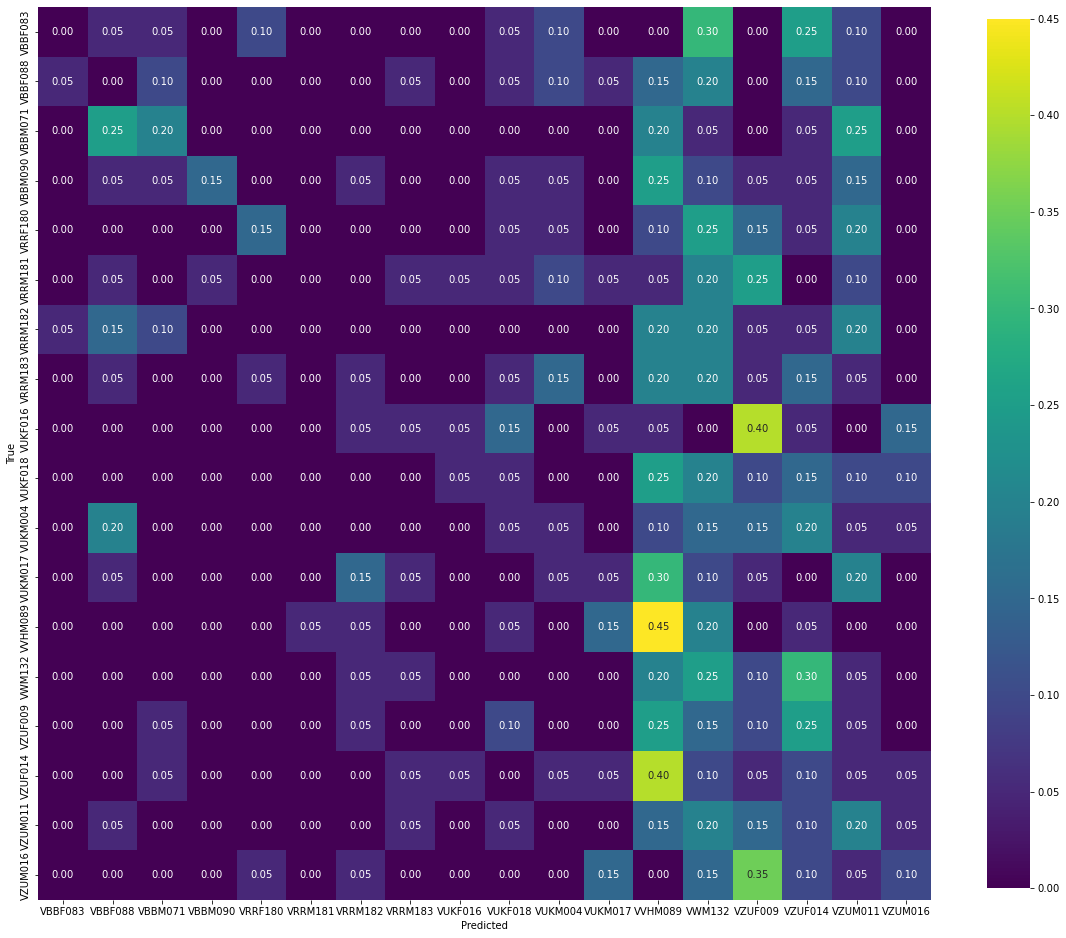

In [30]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_multireg, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_multireg, labels=individuals_test, ax=ax
)
fig.savefig("results_mfccs/multireg/cf_mutlireg.png")

In [31]:
mcc_multireg = evaluate_performance.matthews(y=ytrues, yp=pred_multireg)
kappa_multireg = evaluate_performance.cohen(y=ytrues, yp=pred_multireg)

ROC curve and AUC score

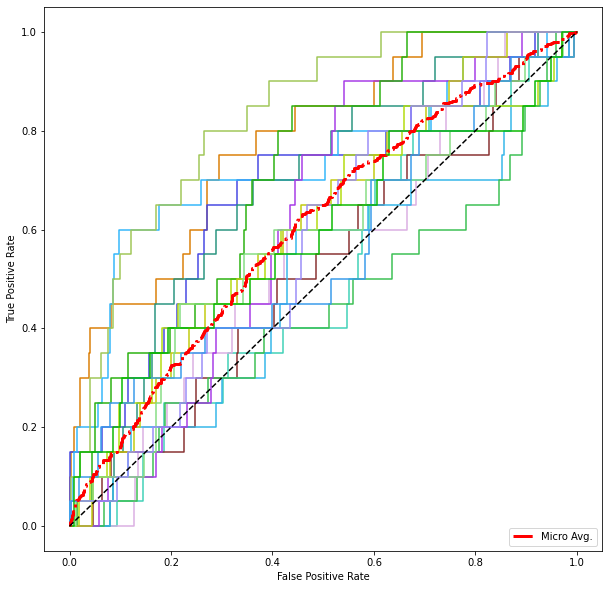

AUC score: 0.612


In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

auc_multireg, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_multireg, n_classes=len(individuals_test), ax=ax
)

fig.savefig("results_mfccs/multireg/roc_multireg.png")
print("AUC score: {:0.3f}".format(auc_multireg))

Metrics

In [33]:
metr_multireg, acc_multireg, f1_multireg = evaluate_performance.metrics(
    y=ytrues, yp=pred_multireg,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_multireg, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)
print("Macro avg. Accuracy: {:0.3f}".format(acc_multireg))
metr_multireg

Macro avg. Accuracy: 0.106


Label  Precision    Recall
0      VBBF083   0.000000  0.000000
1      VBBF088   0.000000  0.000000
2      VBBM071   0.333333  0.200000
3      VBBM090   0.750000  0.150000
4      VRRF180   0.428571  0.150000
5      VRRM181   0.000000  0.000000
6      VRRM182   0.000000  0.000000
7      VRRM183   0.000000  0.000000
8      VUKF016   0.250000  0.050000
9      VUKF018   0.066667  0.050000
10     VUKM004   0.071429  0.050000
11     VUKM017   0.090909  0.050000
12     VVHM089   0.136364  0.450000
13      VWM132   0.083333  0.250000
14     VZUF009   0.050000  0.100000
15     VZUF014   0.048780  0.100000
16     VZUM011   0.105263  0.200000
17     VZUM016   0.200000  0.100000
18  Macro Avg.   0.145258  0.105556

McNemar's test vs. Dummy

In [34]:
stat_multireg, p_multireg, tab_multireg = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy,
    clf2_pred=pred_multireg
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_multireg, p_multireg))

McNemar's test:
	statistic: 4.491
	p-value: 3.407e-02


In [35]:
# save metrics
d = {
    "acc": acc_multireg,
    "auc": auc_multireg,
    "f1": f1_multireg,
    "mcc": mcc_multireg,
    "kappa": kappa_multireg,
    "table": metr_multireg,
    "mcnemar": [stat_multireg, p_multireg]
}
with open("results_mfccs/multireg/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

## **Random Forest:**

In [36]:
# random fores
pred_rf = []
probs_rf = []

times_rf = []

for i in range(10):

    # feature extraction
    X_train, _ = feature_extraction.features(
    signals=train_sig[idxs_train[i]], sample_rates=train_sr[idxs_train[i]]
    )
    X_test, _ = feature_extraction.features(
        signals=test_sig[idxs_test[i]], sample_rates=test_sr[idxs_test[i]]
    )

    # flatten the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
    
    # training
    start = time.perf_counter()
    
    rf = algorithms.RandForest(random_state=i+76, do_umap=False)
    rf.fit(X=X_train, y=y_train[idxs_train[i]])

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = rf.predict(X=X_test)

    pred_rf.append(tmp_pred)
    probs_rf.append(tmp_prob)

    times_rf.append(end-start)

# to arrays
pred_rf = np.array(pred_rf)
probs_rf = np.array(probs_rf)

# reshaping
pred_rf = np.reshape(pred_rf, newshape=(pred_rf.shape[1]*10))
probs_rf = np.reshape(probs_rf, 
    newshape=(probs_rf.shape[1]*10, probs_rf.shape[2]))

In [37]:
# save model
rf.save("models/rf/rf_mfcc.pkl")

In [38]:
# save variables
d = {
    "times": times_rf,
    "pred": pred_rf,
    "probs": probs_rf,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_mfccs/rf/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Random Forest metrics

Confusion Matrix

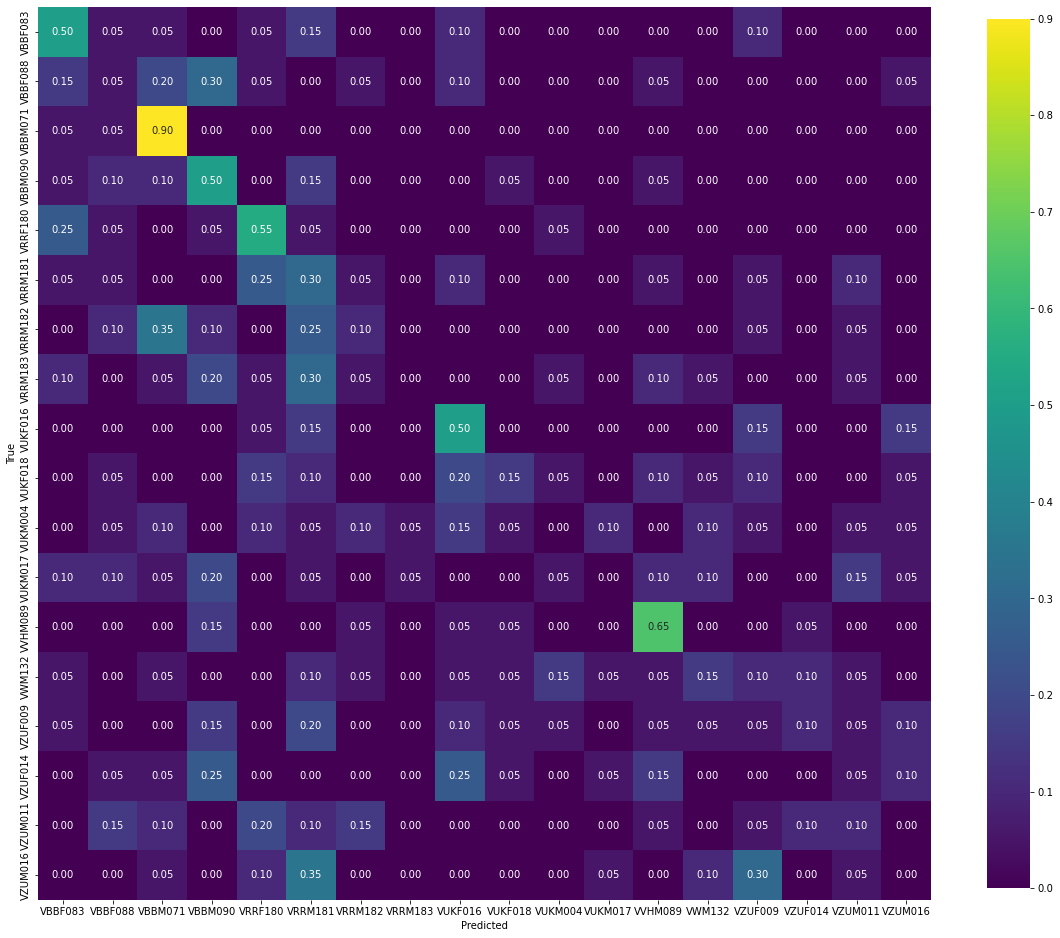

In [39]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
cf_rf, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_rf, labels=individuals_test, ax=ax
)
fig.savefig("results_mfccs/rf/cf_rf.png")

In [40]:
mcc_rf = evaluate_performance.matthews(y=ytrues, yp=pred_rf)
kappa_rf = evaluate_performance.cohen(y=ytrues, yp=pred_rf)

ROC curve and AUC score

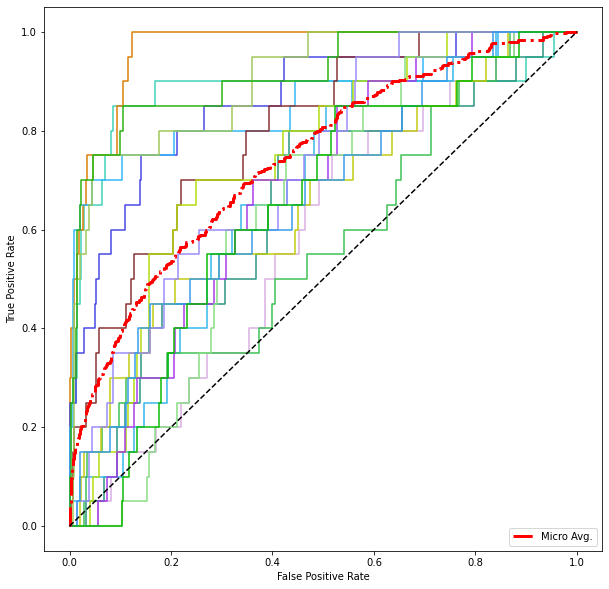

AUC score: 0.744


In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

auc_rf, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_rf, n_classes=len(individuals_test), ax=ax
)
fig.savefig("results_mfccs/rf/roc_rf.png")
print("AUC score: {:0.3f}".format(auc_rf))

Metrics

In [42]:
metr_rf, acc_rf, f1_rf = evaluate_performance.metrics(
    y=ytrues, yp=pred_rf,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_rf, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)
print("Macro avg. Accuracy: {:0.3f}".format(acc_rf))
metr_rf

Macro avg. Accuracy: 0.250


Label  Precision  Recall
0      VBBF083   0.370370    0.50
1      VBBF088   0.058824    0.05
2      VBBM071   0.439024    0.90
3      VBBM090   0.263158    0.50
4      VRRF180   0.354839    0.55
5      VRRM181   0.130435    0.30
6      VRRM182   0.166667    0.10
7      VRRM183   0.000000    0.00
8      VUKF016   0.312500    0.50
9      VUKF018   0.333333    0.15
10     VUKM004   0.000000    0.00
11     VUKM017   0.000000    0.00
12     VVHM089   0.464286    0.65
13      VWM132   0.250000    0.15
14     VZUF009   0.050000    0.05
15     VZUF014   0.000000    0.00
16     VZUM011   0.142857    0.10
17     VZUM016   0.000000    0.00
18  Macro Avg.   0.185350    0.25

McNemar's test vs. Dummy

In [43]:
stat_rf, p_rf, tab_rf = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy,
    clf2_pred=pred_rf
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_rf, p_rf))

McNemar's test:
	statistic: 49.720
	p-value: 1.773e-12


In [44]:
# save metrics
d = {
    "acc": acc_rf,
    "auc": auc_rf,
    "f1": f1_rf,
    "mcc": mcc_rf,
    "kappa": kappa_rf,
    "table": metr_rf,
    "mcnemar": [stat_rf, p_rf]
}
with open("results_mfccs/rf/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

## **Artificial Neural Network (1-hidden MLP):**

In [61]:
# ann
pred_ann = []
probs_ann = []

times_ann = []

for i in range(10):
    
    # feature extraction
    X_train, _ = feature_extraction.features(
    signals=train_sig[idxs_train[i]], sample_rates=train_sr[idxs_train[i]]
    )
    X_test, _ = feature_extraction.features(
        signals=test_sig[idxs_test[i]], sample_rates=test_sr[idxs_test[i]]
    )

    # flatten the data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

    # training
    start = time.perf_counter()
    
    ann = algorithms.MLP(n_classes=len(train.Code.unique()), input_shape=X_train.shape, random_state=i+2, do_umap=True, n_components=45)
    history_ann = ann.fit(
        X=X_train, y=feature_extraction.one_hot(y_train[idxs_train[i]]),
        batch_size=32, epochs=150
        )

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = ann.predict(X=X_test)

    pred_ann.append(tmp_pred)
    probs_ann.append(tmp_prob)

    times_ann.append(end-start)

# to arrays 
pred_ann = np.array(pred_ann)
probs_ann = np.array(probs_ann)

# reshaping
pred_ann = np.reshape(pred_ann, newshape=(pred_ann.shape[1]*10))
probs_ann = np.reshape(probs_ann, 
    newshape=(probs_ann.shape[1]*10, probs_ann.shape[2]))

Epoch 1/150
554/554 - 4s - loss: 4.0114 - accuracy: 0.1062 - val_loss: 7.2207 - val_accuracy: 0.0000e+00
Epoch 2/150
554/554 - 1s - loss: 2.7424 - accuracy: 0.1462 - val_loss: 7.1110 - val_accuracy: 0.0000e+00
Epoch 3/150
554/554 - 1s - loss: 2.5474 - accuracy: 0.1571 - val_loss: 8.3873 - val_accuracy: 0.0000e+00
Epoch 4/150
554/554 - 1s - loss: 2.4899 - accuracy: 0.1624 - val_loss: 8.7704 - val_accuracy: 0.0000e+00
Epoch 5/150
554/554 - 1s - loss: 2.4638 - accuracy: 0.1623 - val_loss: 9.9276 - val_accuracy: 0.0000e+00
Epoch 6/150
554/554 - 1s - loss: 2.4544 - accuracy: 0.1674 - val_loss: 9.7401 - val_accuracy: 0.0000e+00
Epoch 7/150
554/554 - 1s - loss: 2.4414 - accuracy: 0.1686 - val_loss: 10.3164 - val_accuracy: 0.0000e+00
Epoch 8/150
554/554 - 1s - loss: 2.4342 - accuracy: 0.1717 - val_loss: 10.5131 - val_accuracy: 0.0000e+00
Epoch 9/150
554/554 - 1s - loss: 2.4259 - accuracy: 0.1750 - val_loss: 10.4907 - val_accuracy: 0.0000e+00
Epoch 10/150
554/554 - 1s - loss: 2.4206 - accuracy:

In [62]:
# save model
ann.save("models/ann/ann_mfcc.h5")

In [63]:
# save variables
d = {
    "times": times_ann,
    "pred": pred_ann,
    "probs": probs_ann,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_mfccs/ann/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Artificial Neural Network metrics

Confusion Matrix

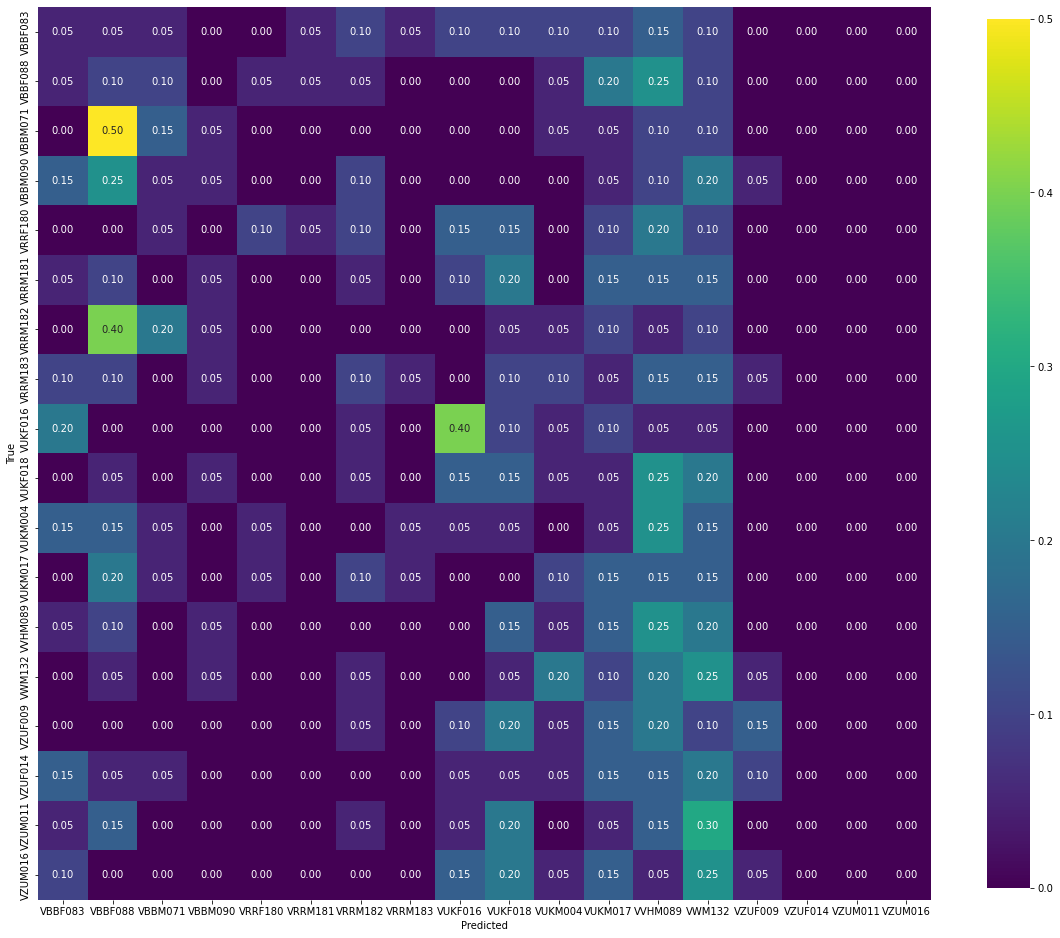

In [64]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_ann, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_ann, labels=individuals_test, ax=ax
)
fig.savefig("results_mfccs/ann/cf_ann.png")

In [65]:
mcc_ann = evaluate_performance.matthews(y=ytrues, yp=pred_ann)
kappa_ann = evaluate_performance.cohen(y=ytrues, yp=pred_ann)

ROC curve and  AUC score

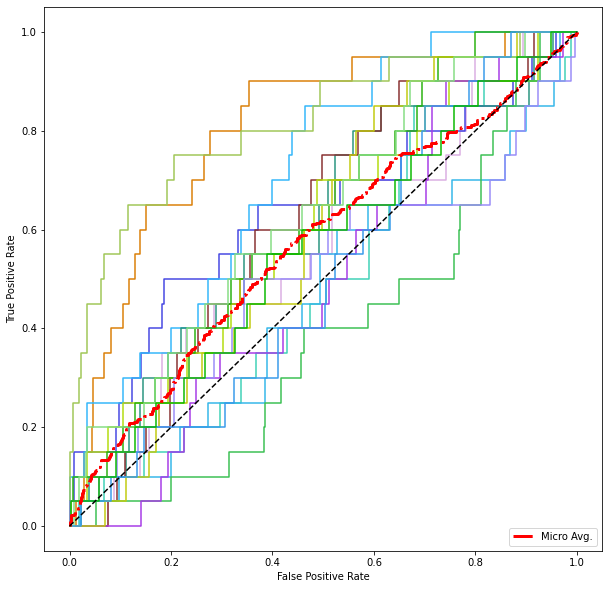

AUC score: 0.589


In [66]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
auc_ann, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_ann, n_classes=len(individuals_test), ax=ax
)
fig.savefig("results_mfccs/ann/roc_ann.png")
print("AUC score: {:0.3f}".format(auc_ann))

Metrics

In [67]:
metr_ann, acc_ann, f1_ann = evaluate_performance.metrics(
    y=ytrues, yp=pred_ann,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_ann, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)
print("Macro avg. Accuracy: {:0.3f}".format(acc_ann))
metr_ann

Macro avg. Accuracy: 0.103


C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn

Label  Precision    Recall
0      VBBF083   0.045455  0.050000
1      VBBF088   0.044444  0.100000
2      VBBM071   0.200000  0.150000
3      VBBM090   0.125000  0.050000
4      VRRF180   0.400000  0.100000
5      VRRM181   0.000000  0.000000
6      VRRM182   0.000000  0.000000
7      VRRM183   0.250000  0.050000
8      VUKF016   0.307692  0.400000
9      VUKF018   0.085714  0.150000
10     VUKM004   0.000000  0.000000
11     VUKM017   0.078947  0.150000
12     VVHM089   0.087719  0.250000
13      VWM132   0.087719  0.250000
14     VZUF009   0.333333  0.150000
15     VZUF014   0.000000  0.000000
16     VZUM011   0.000000  0.000000
17     VZUM016   0.000000  0.000000
18  Macro Avg.   0.113668  0.102778

McNemar's test vs. Dummy

In [68]:
stat_ann, p_ann, tab_ann = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy,
    clf2_pred=pred_ann
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_ann, p_ann))

McNemar's test:
	statistic: 4.018
	p-value: 4.502e-02


In [69]:
# save metrics
d = {
    "acc": acc_ann,
    "auc": auc_ann,
    "f1": f1_ann,
    "mcc": mcc_ann,
    "kappa": kappa_ann,
    "table": metr_ann,
    "mcnemar": [stat_ann, p_ann]
}
with open("results_mfccs/ann/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

## **Convolutional Neural Network (1D):**

In [70]:
%%capture
# cnn
pred_cnn = []
probs_cnn = []

times_cnn = []

for i in range(10):
    
    # feature extraction
    X_train, _ = feature_extraction.features(
    signals=train_sig[idxs_train[i]], sample_rates=train_sr[idxs_train[i]]
    )
    X_test, _ = feature_extraction.features(
        signals=test_sig[idxs_test[i]], sample_rates=test_sr[idxs_test[i]]
    )

    # training
    start = time.perf_counter()
    
    cnn = algorithms.CNN_1D(n_classes=len(train.Code.unique()), input_shape=X_train[0].shape, random_state=i+7)
    history_cnn = cnn.fit(
        X=X_train, y=feature_extraction.one_hot(y_train[idxs_train[i]]),
        batch_size=16, epochs=100
        )

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = cnn.predict(X=X_test)

    pred_cnn.append(tmp_pred)
    probs_cnn.append(tmp_prob)

    times_cnn.append(end-start)

# to arrays
pred_cnn = np.array(pred_cnn)
probs_cnn = np.array(probs_cnn)

# reshaping
pred_cnn = np.reshape(pred_cnn, newshape=(pred_cnn.shape[1]*10))
probs_cnn = np.reshape(probs_cnn, 
    newshape=(probs_cnn.shape[1]*10, probs_cnn.shape[2]))

In [71]:
# save model
cnn.save("models/cnn/cnn_mfcc.h5")

In [72]:
# save variables
d = {
    "times": times_cnn,
    "pred": pred_cnn,
    "probs": probs_cnn,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_mfccs/cnn/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Convolutional Neural Network metrics

Confusion Matrix

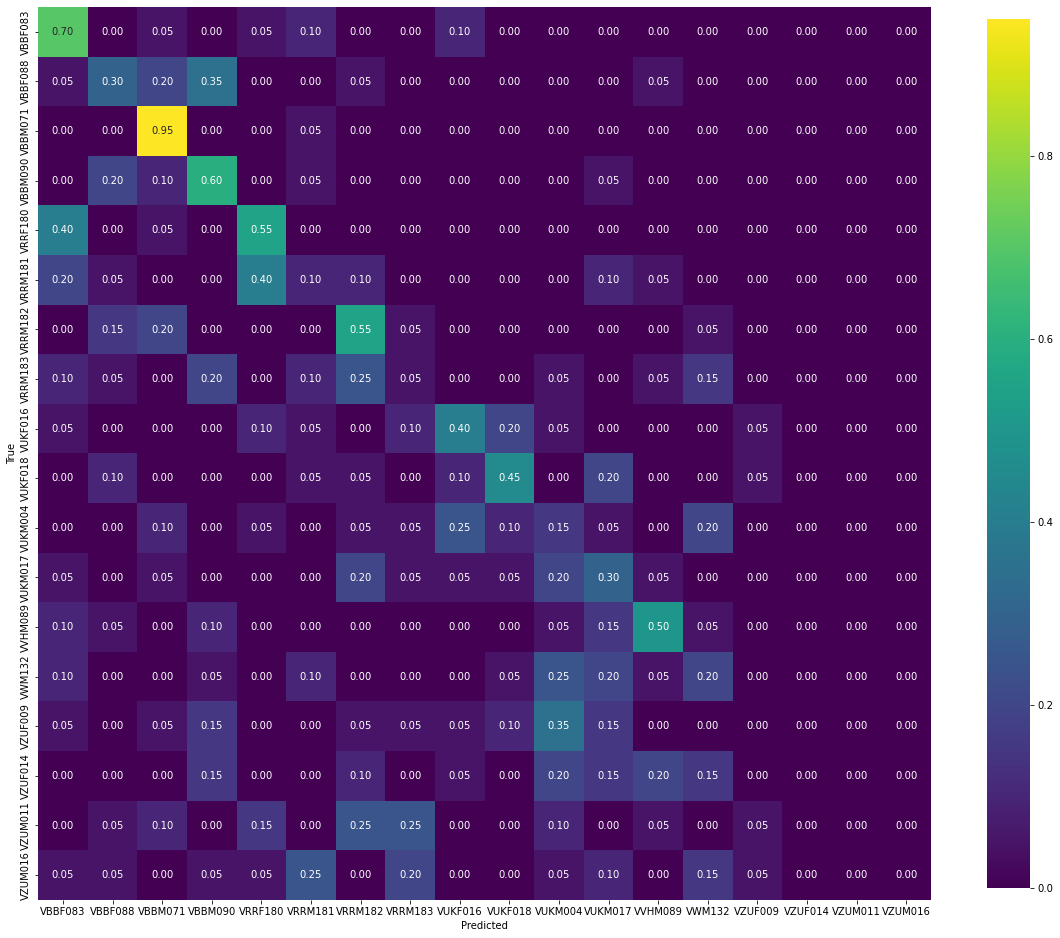

In [73]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_cnn, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_cnn, labels=individuals_test, ax=ax
)
fig.savefig("results_mfccs/cnn/cf_cnn.png")

In [74]:
mcc_cnn = evaluate_performance.matthews(y=ytrues, yp=pred_cnn)
kappa_cnn = evaluate_performance.cohen(y=ytrues, yp=pred_cnn)

ROC curve and  AUC score

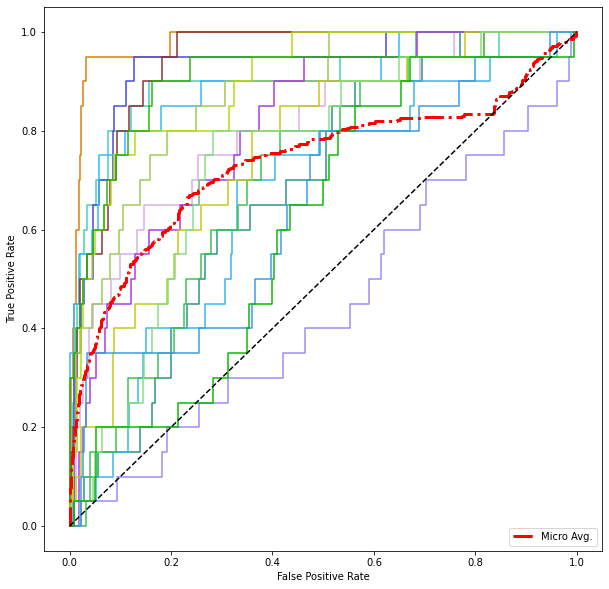

AUC score: 0.789


In [75]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
auc_cnn, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_cnn, n_classes=len(individuals_test), ax=ax
)
fig.savefig("results_mfccs/cnn/roc_cnn.png")
print("AUC score: {:0.3f}".format(auc_cnn))

Metrics

In [76]:
metr_cnn, acc_cnn, f1_cnn = evaluate_performance.metrics(
    y=ytrues, yp=pred_cnn,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_cnn, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)
print("Macro avg. Accuracy: {:0.3f}".format(acc_cnn))
metr_cnn

Macro avg. Accuracy: 0.322


C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn

Label  Precision    Recall
0      VBBF083   0.378378  0.700000
1      VBBF088   0.300000  0.300000
2      VBBM071   0.513514  0.950000
3      VBBM090   0.363636  0.600000
4      VRRF180   0.407407  0.550000
5      VRRM181   0.117647  0.100000
6      VRRM182   0.333333  0.550000
7      VRRM183   0.062500  0.050000
8      VUKF016   0.400000  0.400000
9      VUKF018   0.473684  0.450000
10     VUKM004   0.103448  0.150000
11     VUKM017   0.206897  0.300000
12     VVHM089   0.500000  0.500000
13      VWM132   0.210526  0.200000
14     VZUF009   0.000000  0.000000
15     VZUF014   0.000000  0.000000
16     VZUM011   0.000000  0.000000
17     VZUM016   0.000000  0.000000
18  Macro Avg.   0.242832  0.322222

McNemar's test vs. Dummy

In [77]:
stat_cnn, p_cnn, tab_cnn = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy,
    clf2_pred=pred_cnn
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_cnn, p_cnn))

McNemar's test:
	statistic: 70.688
	p-value: 4.184e-17


In [78]:
# save metrics
d = {
    "acc": acc_cnn,
    "auc": auc_cnn,
    "f1": f1_cnn,
    "mcc": mcc_cnn,
    "kappa": kappa_cnn,
    "table": metr_cnn,
    "mcnemar": [stat_cnn, p_cnn]
}
with open("results_mfccs/cnn/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

# **Spectrograms**

In [79]:
del train_sig, test_sig, train_sr, test_sr

In [27]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/")

In [3]:
# import the data
train = pd.read_csv("code/general_identification/datasets/spec_training_bal.csv", index_col=0)
test = pd.read_csv("code/general_identification/datasets/testing_specs.csv", index_col=0)

In [4]:
print(train.shape)
train.head()

(221490, 12)


GroupName Sex  AgeDays  AgeYears     RecDate  \
index                                                
41       Baobab   F      948  2.597260  17/09/2014   
65       Baobab   F      948  2.597260  17/09/2014   
58       Baobab   F      948  2.597260  17/09/2014   
121      Baobab   F      884  2.421918  15/07/2014   
26       Baobab   F      948  2.597260  17/09/2014   

                           SourceFile     Code    ID  \
index                                                  
41     VBBF083_BB_2_AM_17SEPT2014.WAV  VBBF083  2741   
65     VBBF083_BB_2_AM_17SEPT2014.WAV  VBBF083  2741   
58     VBBF083_BB_2_AM_17SEPT2014.WAV  VBBF083  2741   
121       VBBF083_BB_2_15July2014.WAV  VBBF083  2741   
26     VBBF083_BB_1_AM_17SEPT2014.WAV  VBBF083  2741   

                                   CallFile CallTime CallType  \
index                                                           
41     VBBF083_BB_2_AM_17SEPT2014_AD_01.WAV  00:34.3       SC   
65     VBBF083_BB_2_AM_17SEPT2014_AD_28.WAV  07:23.0       SC   
58     VBBF083_BB_2_AM_17SEPT2014_AD_20.WAV  05:04.6       SC   
121       VBBF083_BB_2_15July2014_AD_30.WAV  04:26.5       FO   
26     VBBF083_BB_1_AM_17SEPT2014_AD_29.WAV  02:38.4       SC   

                                                    Path  
index                                                     
41     spectrograms\VBBF083\VBBF083_BB_2_AM_17SEPT201...  
65     spectrograms\VBBF083\VBBF083_BB_2_AM_17SEPT201...  
58     spectrograms\VBBF083\VBBF083_BB_2_AM_17SEPT201...  
121    spectrograms\VBBF083\VBBF083_BB_2_15July2014_A...  
26     spectrograms\VBBF083\VBBF083_BB_1_AM_17SEPT201...

In [5]:
print(test.shape)
test.head()

(522, 12)


GroupName Sex  AgeDays  AgeYears     RecDate  \
index                                                
8        Baobab   F      883  2.419178  14/07/2014   
19       Baobab   F      941  2.578082  10/09/2014   
2        Baobab   F      883  2.419178  14/07/2014   
26       Baobab   F      941  2.578082  10/09/2014   
22       Baobab   F      941  2.578082  10/09/2014   

                           SourceFile     Code    ID  \
index                                                  
8      VBBF083_BB_1_PM_14July2014.WAV  VBBF083  2741   
19     VBBF083_BB_1_PM_10SEPT2014.WAV  VBBF083  2741   
2      VBBF083_BB_1_PM_14July2014.WAV  VBBF083  2741   
26     VBBF083_BB_1_PM_10SEPT2014.WAV  VBBF083  2741   
22     VBBF083_BB_1_PM_10SEPT2014.WAV  VBBF083  2741   

                                   CallFile CallTime CallType  \
index                                                           
8      VBBF083_BB_1_PM_14July2014_AD_09.WAV  01:29.3       SC   
19     VBBF083_BB_1_PM_10SEPT2014_AD_02.WAV  00:48.4       SC   
2      VBBF083_BB_1_PM_14July2014_AD_03.WAV  00:50.5       SC   
26     VBBF083_BB_1_PM_10SEPT2014_AD_14.WAV  09:59.3       FO   
22     VBBF083_BB_1_PM_10SEPT2014_AD_05.WAV  02:16.9       SC   

                                                    Path  
index                                                     
8      spectrograms\VBBF083\VBBF083_BB_1_PM_14July201...  
19     spectrograms\VBBF083\VBBF083_BB_1_PM_10SEPT201...  
2      spectrograms\VBBF083\VBBF083_BB_1_PM_14July201...  
26     spectrograms\VBBF083\VBBF083_BB_1_PM_10SEPT201...  
22     spectrograms\VBBF083\VBBF083_BB_1_PM_10SEPT201...

In [5]:
# random sorting 
train = train.sample(frac=1, ignore_index=True, random_state=33).reset_index()
test = test.sample(frac=1, ignore_index=True, random_state=33).reset_index()

In [6]:
# random selections for train-test-split
np.random.seed(32)
idxs_train = [train.groupby("Code").sample(n=train.groupby(["Code"]).size().min()//10, random_state=np.random.randint(0, 100)).index.to_list() for i in range(10)]
idxs_test = [test.groupby("Code").sample(n=test.groupby(["Code"]).size().min()//10, random_state=np.random.randint(0, 100)).index.to_list() for i in range(10)]

In [7]:
# define the targets
y_train, _ = feature_extraction.get_targets(metadata_df=train, show_distribution=False)
y_test, individuals_test = feature_extraction.get_targets(metadata_df=test, show_distribution=False)

## **Baseline Dummy classifier (using stratified startegy):**

In [29]:
# dummy classifier
pred_dummy = [] # predicted list
probs_dummy = [] # predicted probabilities list
ytrues = [] # list of true labels

dummy_times = [] # time elapsed list

# train and test 10 times on different subsets of data
for i in range(1):
    
    # load in batches the spectrograms
    X_train, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=train.iloc[idxs_train[i]], directory=None, created=True
    )
    X_test, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=test.iloc[idxs_test[i]], directory=None, created=True
    )

    # reshaping
    X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
    X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))

    # training
    start = time.perf_counter()

    dummy = algorithms.Dummy(random_state=i+33)
    dummy.fit(X=X_train, y=y_train[idxs_train[i]])

    end = time.perf_counter()

    # model evaluation
    tmp_pred, tmp_prob = dummy.predict(X=X_test)

    pred_dummy.append(tmp_pred)
    probs_dummy.append(tmp_prob)
    ytrues.append(y_test[idxs_test[i]])

    dummy_times.append(end-start)

# to arrays
pred_dummy = np.array(pred_dummy)
probs_dummy = np.array(probs_dummy)
ytrues = np.array(ytrues)

# reshaping the arrays to the correct shape (as if it was all one test)
pred_dummy = np.reshape(pred_dummy, newshape=(pred_dummy.shape[1]*1))
probs_dummy = np.reshape(probs_dummy, 
    newshape=(probs_dummy.shape[1]*1, probs_dummy.shape[2]))
ytrues = np.reshape(ytrues, newshape=(ytrues.shape[1]*1))

In [30]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/code/general_identification/")

In [99]:
# save variables
d = {
    "times": dummy_times,
    "pred": pred_dummy,
    "probs": probs_dummy,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_specs/dummy/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Dummy metrics

Confusion Matrix

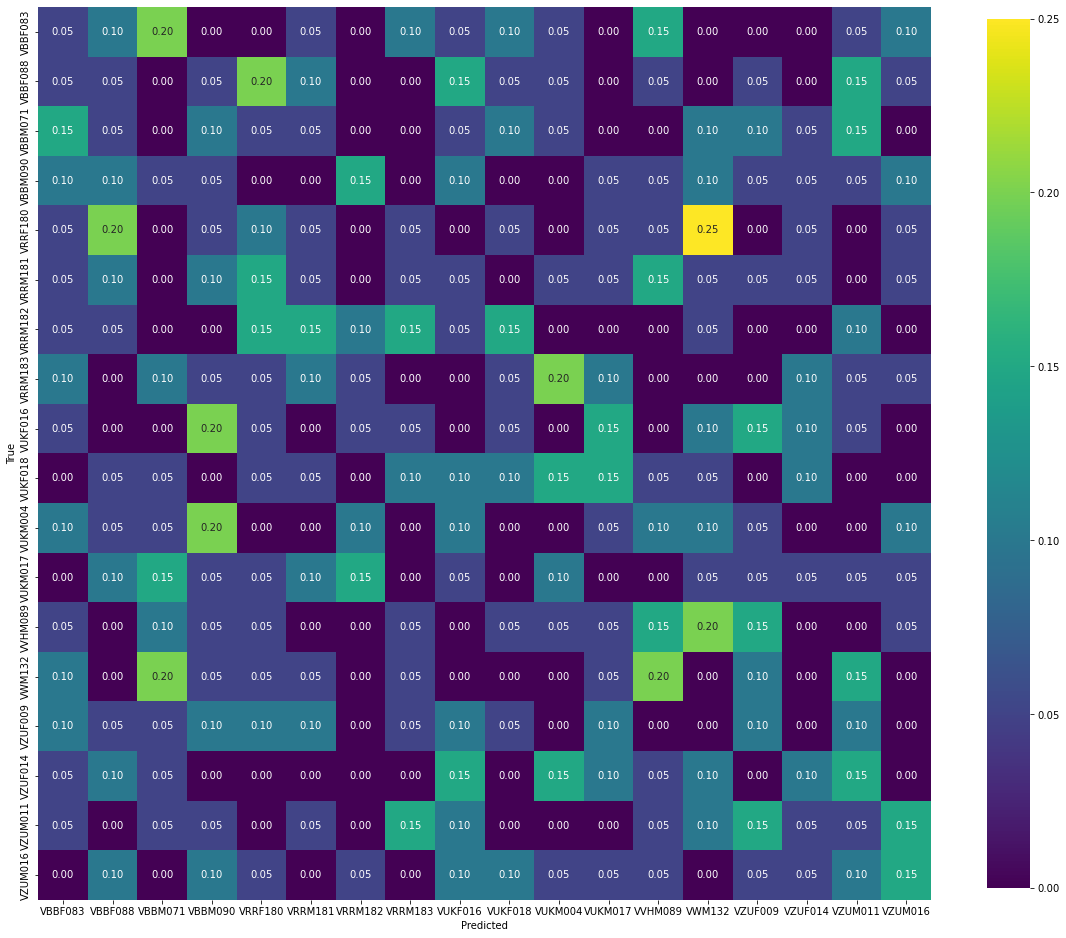

In [100]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_dummy, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_dummy, labels=individuals_test, ax=ax 
)
fig.savefig("results_specs/dummy/cf_dummy.png")

In [101]:
mcc_dummy = evaluate_performance.matthews(y=ytrues, yp=pred_dummy)
kappa_dummy = evaluate_performance.cohen(y=ytrues, yp=pred_dummy)

ROC curve and AUC score

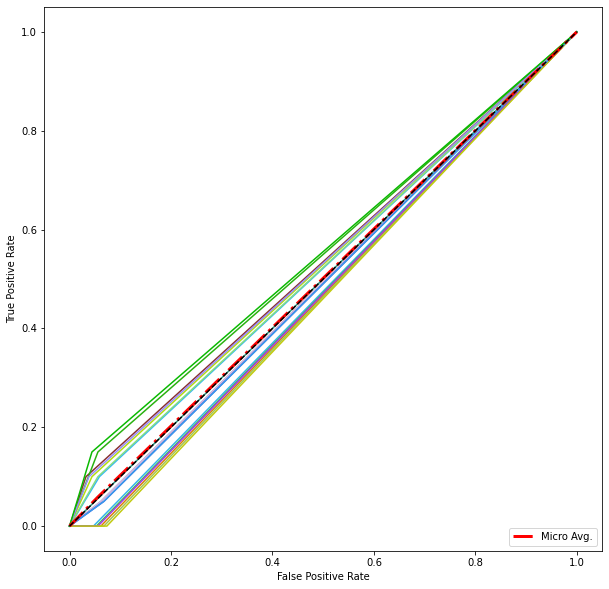

AUC score: 0.501


In [102]:
# dummy classifier metrics
fig, ax = plt.subplots(1,1, figsize=(10,10))

auc_dummy, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
     y_score=probs_dummy, n_classes=len(np.unique(ytrues)),
     ax=ax
    )
fig.savefig("results_specs/dummy/roc_dummy.png")

print("AUC score: {:0.3f}".format(auc_dummy))

Metrics

In [103]:
metr_dummy, acc_dummy, f1_dummy = evaluate_performance.metrics(
    y=ytrues, yp=pred_dummy,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_dummy, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)

# save metrics
d = {
    "acc": acc_dummy,
    "auc": auc_dummy,
    "f1": f1_dummy,
    "mcc": mcc_dummy,
    "kappa": kappa_dummy,
    "table": metr_dummy
}
with open("results_specs/dummy/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

print("Macro avg. Accuracy: {:0.3f}".format(acc_dummy))
metr_dummy

Macro avg. Accuracy: 0.058


Label  Precision    Recall
0      VBBF083   0.045455  0.050000
1      VBBF088   0.045455  0.050000
2      VBBM071   0.000000  0.000000
3      VBBM090   0.041667  0.050000
4      VRRF180   0.090909  0.100000
5      VRRM181   0.055556  0.050000
6      VRRM182   0.153846  0.100000
7      VRRM183   0.000000  0.000000
8      VUKF016   0.000000  0.000000
9      VUKF018   0.117647  0.100000
10     VUKM004   0.000000  0.000000
11     VUKM017   0.000000  0.000000
12     VVHM089   0.136364  0.150000
13      VWM132   0.000000  0.000000
14     VZUF009   0.095238  0.100000
15     VZUF014   0.133333  0.100000
16     VZUM011   0.041667  0.050000
17     VZUM016   0.166667  0.150000
18  Macro Avg.   0.062433  0.058333

## **K-Means clustering classifier:**

In [104]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/")

In [105]:
# k-means
pred_km = []
probs_km = []

times_km = []

for i in range(10):

    # load in batches the spectrograms
    X_train, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=train.iloc[idxs_train[i]], directory=None, created=True
    )
    X_test, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=test.iloc[idxs_test[i]], directory=None, created=True
    )

    # reshaping
    X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
    X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
    
    # training
    start = time.perf_counter()
    
    km = algorithms.Kmeans(n_classes=len(train.Code.unique()), random_state=i+53, do_umap=True, n_components=128)
    km.fit(X=X_train, y=y_train[idxs_train[i]])

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = km.predict(X=X_test, y_test=y_test[idxs_test[i]])
  
    pred_km.append(tmp_pred)
    probs_km.append(tmp_prob)

    times_km.append(end-start)

# to arrays
pred_km = np.array(pred_km)
probs_km = np.array(probs_km)

# reshaping
pred_km = np.reshape(pred_km, newshape=(pred_km.shape[1]*10))
probs_km = np.reshape(probs_km, 
    newshape=(probs_km.shape[1]*10, probs_km.shape[2]))

In [106]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/code/general_identification/")

In [107]:
# save model
km.save("models/kmeans/km_specs.pkl")

In [108]:
# save variables
d = {
    "times": times_km,
    "pred": pred_km,
    "probs": probs_km,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_specs/kmeans/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### K-means metrics

Confusion Matrix

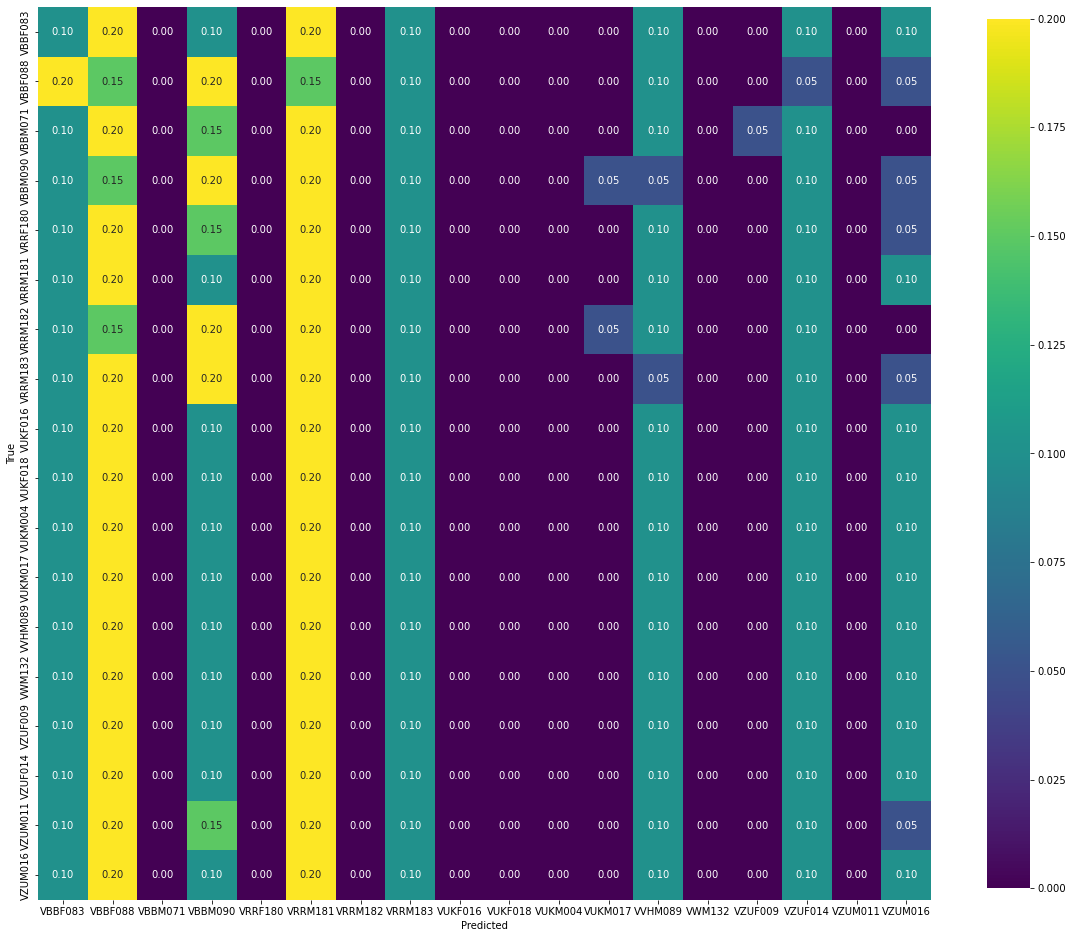

In [109]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_km, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_km, labels=individuals_test, ax=ax
)
fig.savefig("results_specs/kmeans/cf_km.png")

In [110]:
mcc_km = evaluate_performance.matthews(y=ytrues, yp=pred_km)
kappa_km = evaluate_performance.cohen(y=ytrues, yp=pred_km)

ROC curve and AUC score

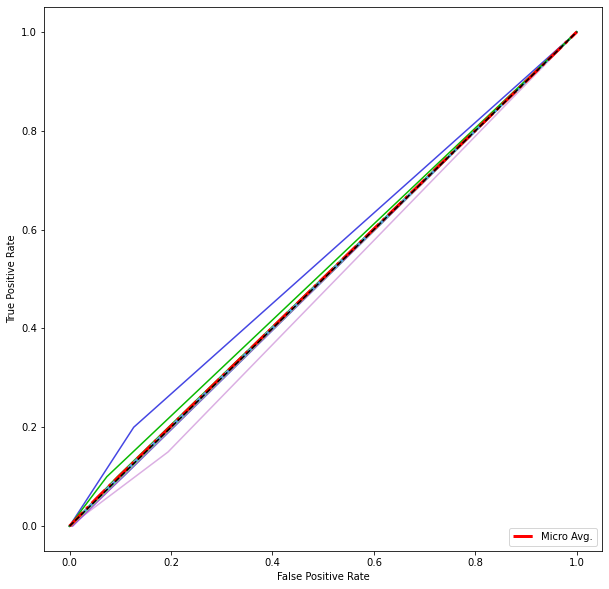

AUC score: 0.501


In [111]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

auc_km, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_km, n_classes=len(individuals_test), ax=ax
)
fig.savefig("results_specs/kmeans/roc_km.png")
print("AUC score: {:0.3f}".format(auc_km))

Metrics

In [112]:
metr_km, acc_km, f1_km = evaluate_performance.metrics(
    y=ytrues, yp=pred_km,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_km, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)

print("Macro avg. Accuracy: {:0.3f}".format(acc_km))
metr_km

C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn

Macro avg. Accuracy: 0.058


Label  Precision    Recall
0      VBBF083   0.052632  0.100000
1      VBBF088   0.043478  0.150000
2      VBBM071   0.000000  0.000000
3      VBBM090   0.085106  0.200000
4      VRRF180   0.000000  0.000000
5      VRRM181   0.056338  0.200000
6      VRRM182   0.000000  0.000000
7      VRRM183   0.055556  0.100000
8      VUKF016   0.000000  0.000000
9      VUKF018   0.000000  0.000000
10     VUKM004   0.000000  0.000000
11     VUKM017   0.000000  0.000000
12     VVHM089   0.058824  0.100000
13      VWM132   0.000000  0.000000
14     VZUF009   0.000000  0.000000
15     VZUF014   0.057143  0.100000
16     VZUM011   0.000000  0.000000
17     VZUM016   0.074074  0.100000
18  Macro Avg.   0.026842  0.058333

McNemar's test vs. Dummy

In [113]:
stat_km, p_km, tab_km = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy,
    clf2_pred=pred_km
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_km, p_km))

McNemar's test:
	statistic: 0.024
	p-value: 8.774e-01


In [114]:
# save metrics
d = {
    "acc": acc_km,
    "auc": auc_km,
    "f1": f1_km,
    "mcc": mcc_km,
    "kappa": kappa_km,
    "table": metr_km,
    "mcnemar": [stat_km, p_km]
}
with open("results_specs/kmeans/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

## **Multinomial Regression Classifier:**

In [10]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/")

In [11]:
# multinomial regression
pred_multireg = []
probs_multireg = []

times_multireg = []

for i in range(10):

    # load in batches the spectrograms
    X_train, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=train.iloc[idxs_train[i]], directory=None, created=True
    )
    X_test, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=test.iloc[idxs_test[i]], directory=None, created=True
    )

    # reshaping
    X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
    X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
    
    # training
    start = time.perf_counter()
    
    multireg = algorithms.MultinomReg(random_state=i+42, do_umap=True, n_components=128)
    multireg.fit(X=X_train, y=y_train[idxs_train[i]])

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = multireg.predict(X=X_test)

    pred_multireg.append(tmp_pred)
    probs_multireg.append(tmp_prob)

    times_multireg.append(end-start)

# to arrays
pred_multireg = np.array(pred_multireg)
probs_multireg = np.array(probs_multireg)

# reshaping
pred_multireg = np.reshape(pred_multireg, newshape=(pred_multireg.shape[1]*10))
probs_multireg = np.reshape(probs_multireg, 
    newshape=(probs_multireg.shape[1]*10, probs_multireg.shape[2]))

In [27]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/code/general_identification/")

In [28]:
# save model
multireg.save("models/multireg/multireg_specs.pkl")

In [29]:
# save variables
d = {
    "times": times_multireg,
    "pred": pred_multireg,
    "probs": probs_multireg,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_specs/multireg/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Multinomial Regression metrics

Confusion matrix

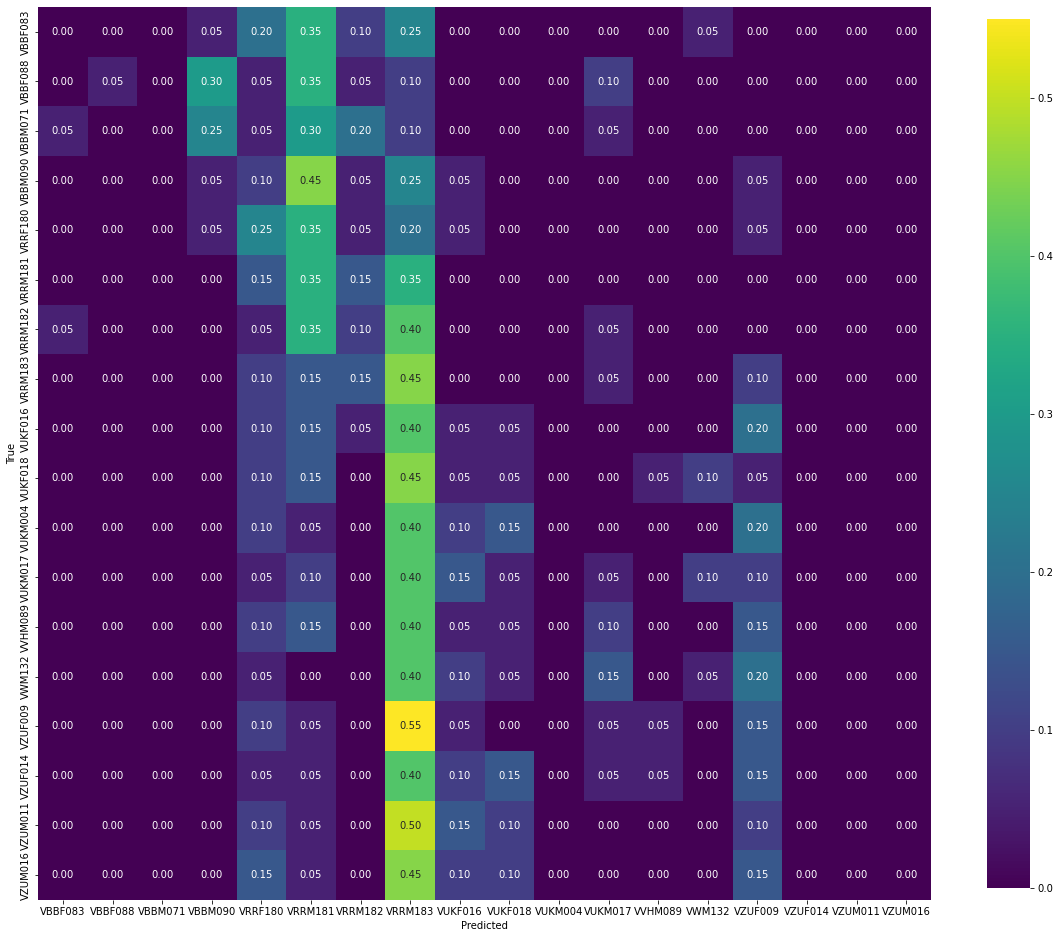

In [30]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_multireg, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_multireg, labels=individuals_test, ax=ax
)
fig.savefig("results_specs/multireg/cf_mutlireg.png")

In [31]:
mcc_multireg = evaluate_performance.matthews(y=ytrues, yp=pred_multireg)
kappa_multireg = evaluate_performance.cohen(y=ytrues, yp=pred_multireg)

ROC curve and AUC score

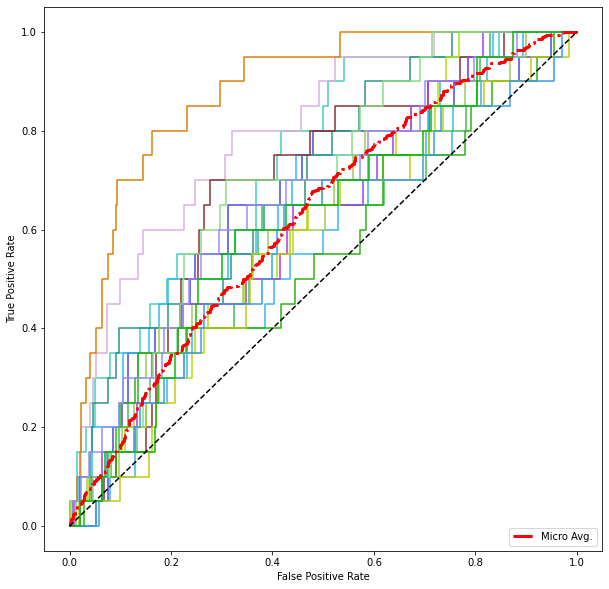

AUC score: 0.658


In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

auc_multireg, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_multireg, n_classes=len(individuals_test), ax=ax
)

fig.savefig("results_specs/multireg/roc_multireg.png")
print("AUC score: {:0.3f}".format(auc_multireg))

Metrics

In [33]:
metr_multireg, acc_multireg, f1_multireg = evaluate_performance.metrics(
    y=ytrues, yp=pred_multireg,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_multireg, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)
print("Macro avg. Accuracy: {:0.3f}".format(acc_multireg))
metr_multireg

C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn

Macro avg. Accuracy: 0.089


Label  Precision    Recall
0      VBBF083   0.000000  0.000000
1      VBBF088   1.000000  0.050000
2      VBBM071   0.000000  0.000000
3      VBBM090   0.071429  0.050000
4      VRRF180   0.135135  0.250000
5      VRRM181   0.101449  0.350000
6      VRRM182   0.111111  0.100000
7      VRRM183   0.069767  0.450000
8      VUKF016   0.050000  0.050000
9      VUKF018   0.066667  0.050000
10     VUKM004   0.000000  0.000000
11     VUKM017   0.076923  0.050000
12     VVHM089   0.000000  0.000000
13      VWM132   0.166667  0.050000
14     VZUF009   0.090909  0.150000
15     VZUF014   0.000000  0.000000
16     VZUM011   0.000000  0.000000
17     VZUM016   0.000000  0.000000
18  Macro Avg.   0.107781  0.088889

McNemar's test vs. Dummy

In [34]:
stat_multireg, p_multireg, tab_multireg = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy,
    clf2_pred=pred_multireg
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_multireg, p_multireg))

McNemar's test:
	statistic: 2.128
	p-value: 1.447e-01


In [35]:
# save metrics
d = {
    "acc": acc_multireg,
    "auc": auc_multireg,
    "f1": f1_multireg,
    "mcc": mcc_multireg,
    "kappa": kappa_multireg,
    "table": metr_multireg,
    "mcnemar": [stat_multireg, p_multireg]
}
with open("results_specs/multireg/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

## **Random Forest:**

In [36]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/")

In [37]:
# random forest
pred_rf = []
probs_rf = []

times_rf = []

for i in range(10):

    # load in batches the spectrograms
    X_train, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=train.iloc[idxs_train[i]], directory=None, created=True
    )
    X_test, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=test.iloc[idxs_test[i]], directory=None, created=True
    )

    # reshaping
    X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
    X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
    
    # training
    start = time.perf_counter()
    
    rf = algorithms.RandForest(random_state=i+76, do_umap=False)
    rf.fit(X=X_train, y=y_train[idxs_train[i]])

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = rf.predict(X=X_test)

    pred_rf.append(tmp_pred)
    probs_rf.append(tmp_prob)

    times_rf.append(end-start)

# to arrays
pred_rf = np.array(pred_rf)
probs_rf = np.array(probs_rf)

# reshaping
pred_rf = np.reshape(pred_rf, newshape=(pred_rf.shape[1]*10))
probs_rf = np.reshape(probs_rf, 
    newshape=(probs_rf.shape[1]*10, probs_rf.shape[2]))

In [38]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/code/general_identification/")

In [39]:
# save model
rf.save("models/rf/rf_specs.pkl")

In [40]:
# save variables
d = {
    "times": times_rf,
    "pred": pred_rf,
    "probs": probs_rf,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_specs/rf/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Random Forest metrics

Confusion Matrix

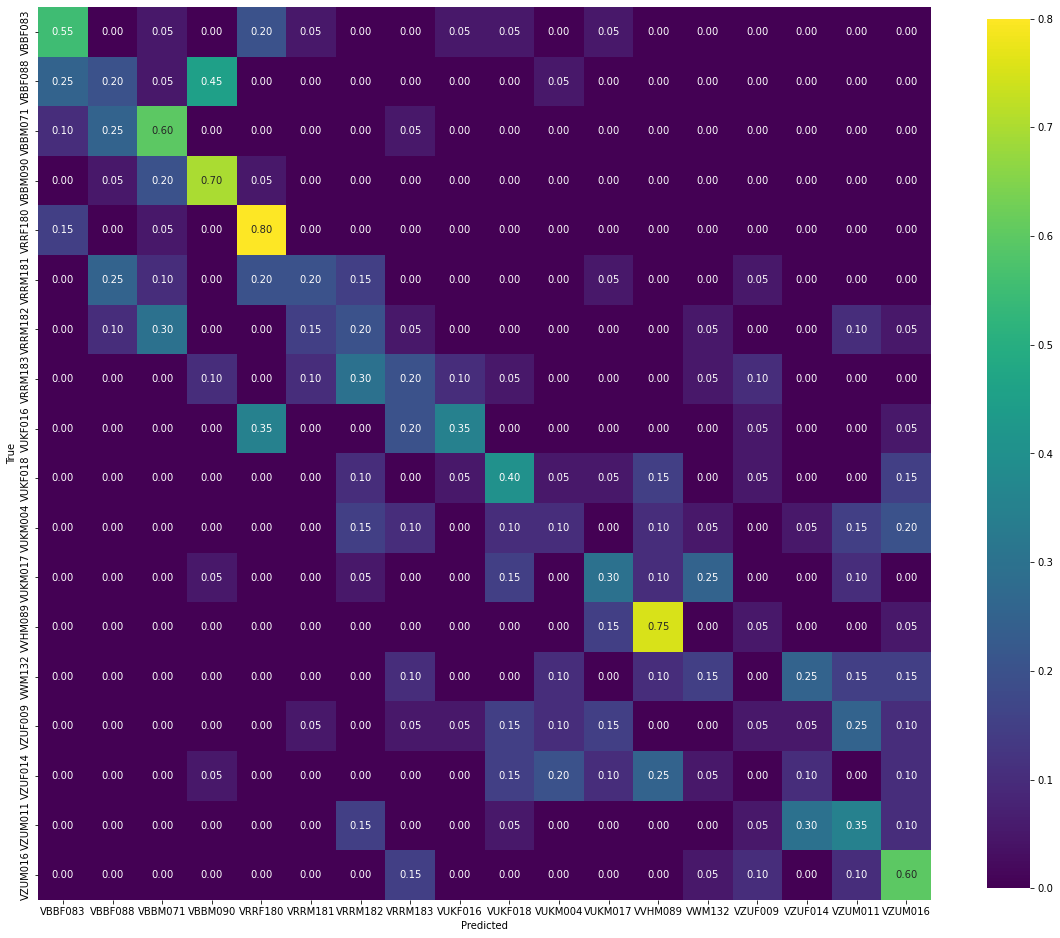

In [41]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
cf_rf, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_rf, labels=individuals_test, ax=ax
)
fig.savefig("results_specs/rf/cf_rf.png")

In [42]:
mcc_rf = evaluate_performance.matthews(y=ytrues, yp=pred_rf)
kappa_rf = evaluate_performance.cohen(y=ytrues, yp=pred_rf)

ROC curve and AUC score

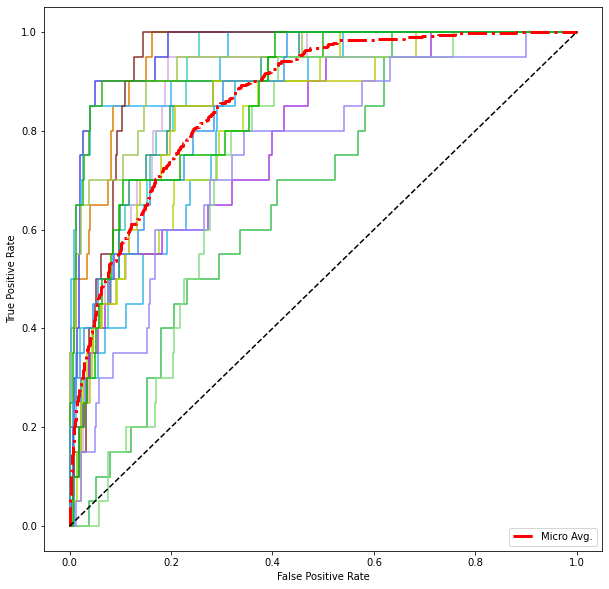

AUC score: 0.865


In [43]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

auc_rf, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_rf, n_classes=len(individuals_test), ax=ax
)
fig.savefig("results_specs/rf/roc_rf.png")
print("AUC score: {:0.3f}".format(auc_rf))

Metrics

In [44]:
metr_rf, acc_rf, f1_rf = evaluate_performance.metrics(
    y=ytrues, yp=pred_rf,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_rf, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)
print("Macro avg. Accuracy: {:0.3f}".format(acc_rf))
metr_rf

Macro avg. Accuracy: 0.367


Label  Precision    Recall
0      VBBF083   0.523810  0.550000
1      VBBF088   0.235294  0.200000
2      VBBM071   0.444444  0.600000
3      VBBM090   0.518519  0.700000
4      VRRF180   0.500000  0.800000
5      VRRM181   0.363636  0.200000
6      VRRM182   0.181818  0.200000
7      VRRM183   0.222222  0.200000
8      VUKF016   0.583333  0.350000
9      VUKF018   0.363636  0.400000
10     VUKM004   0.166667  0.100000
11     VUKM017   0.352941  0.300000
12     VVHM089   0.517241  0.750000
13      VWM132   0.230769  0.150000
14     VZUF009   0.100000  0.050000
15     VZUF014   0.133333  0.100000
16     VZUM011   0.291667  0.350000
17     VZUM016   0.387097  0.600000
18  Macro Avg.   0.339802  0.366667

McNemar's test vs. Dummy

In [45]:
stat_rf, p_rf, tab_rf = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy,
    clf2_pred=pred_rf
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_rf, p_rf))

McNemar's test:
	statistic: 89.630
	p-value: 2.872e-21


In [46]:
# save metrics
d = {
    "acc": acc_rf,
    "auc": auc_rf,
    "f1": f1_rf,
    "mcc": mcc_rf,
    "kappa": kappa_rf,
    "table": metr_rf,
    "mcnemar": [stat_rf, p_rf]
}
with open("results_specs/rf/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

## **Artificial Neural Network (1-hidden MLP):**

In [47]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/")

In [48]:
%%capture
# ann
pred_ann = []
probs_ann = []

times_ann = []

for i in range(10):

    # load in batches the spectrograms
    X_train, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=train.iloc[idxs_train[i]], directory=None, created=True
    )
    X_test, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=test.iloc[idxs_test[i]], directory=None, created=True
    )

    # reshaping
    X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
    X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
    
    # training
    start = time.perf_counter()
    
    ann = algorithms.MLP(n_classes=len(train.Code.unique()), input_shape=X_train.shape, random_state=i+2, do_umap=True, n_components=128)
    history_ann = ann.fit(
        X=X_train, y=feature_extraction.one_hot(y_train[idxs_train[i]]),
        batch_size=64, epochs=100
        )

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = ann.predict(X=X_test)

    pred_ann.append(tmp_pred)
    probs_ann.append(tmp_prob)

    times_ann.append(end-start)

# to arrays
pred_ann = np.array(pred_ann)
probs_ann = np.array(probs_ann)

# reshaping
pred_ann = np.reshape(pred_ann, newshape=(pred_ann.shape[1]*10))
probs_ann = np.reshape(probs_ann, 
    newshape=(probs_ann.shape[1]*10, probs_ann.shape[2]))

In [49]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/code/general_identification/")

In [50]:
# save model
ann.save("models/ann/ann_specs.h5")

In [51]:
# save variables
d = {
    "times": times_ann,
    "pred": pred_ann,
    "probs": probs_ann,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_specs/ann/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Artificial Neural Network metrics

Confusion Matrix

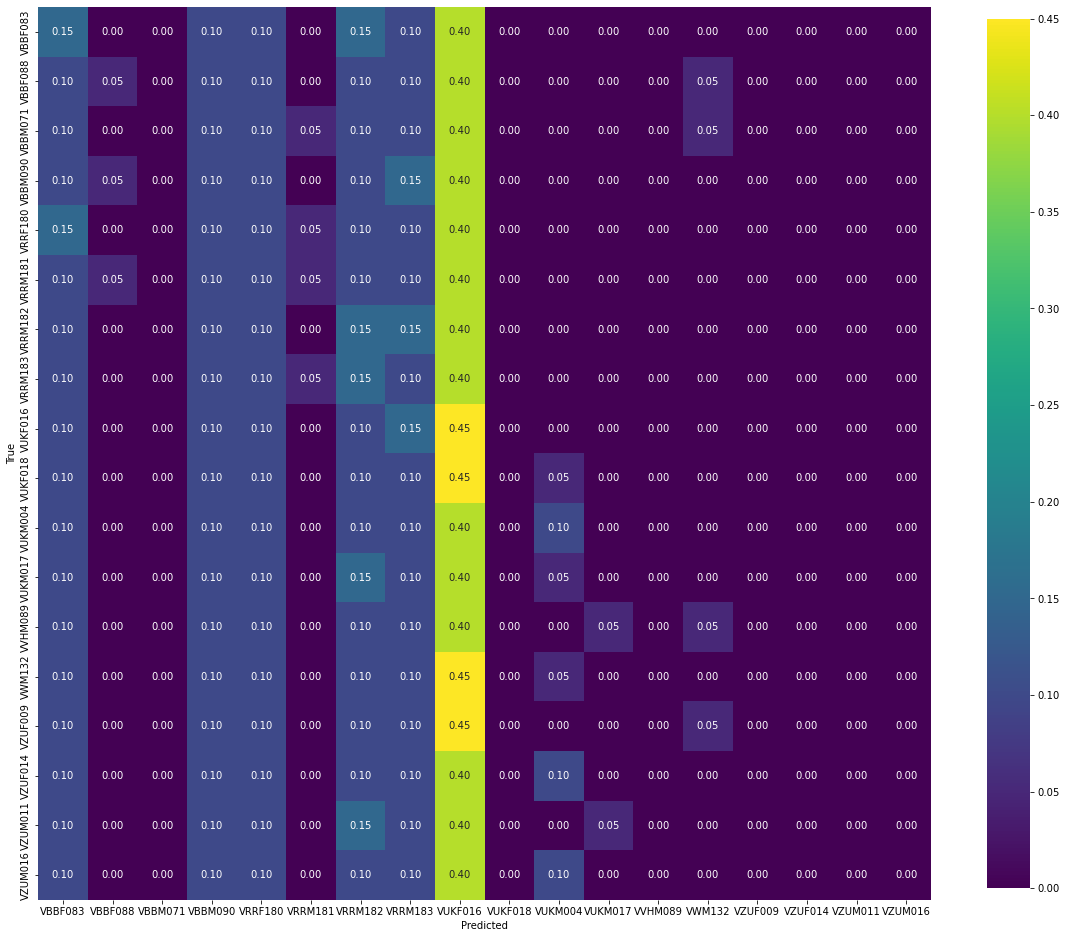

In [52]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_ann, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_ann, labels=individuals_test, ax=ax
)
fig.savefig("results_specs/ann/cf_ann.png")

In [53]:
mcc_ann = evaluate_performance.matthews(y=ytrues, yp=pred_ann)
kappa_ann = evaluate_performance.cohen(y=ytrues, yp=pred_ann)

ROC curve and  AUC score

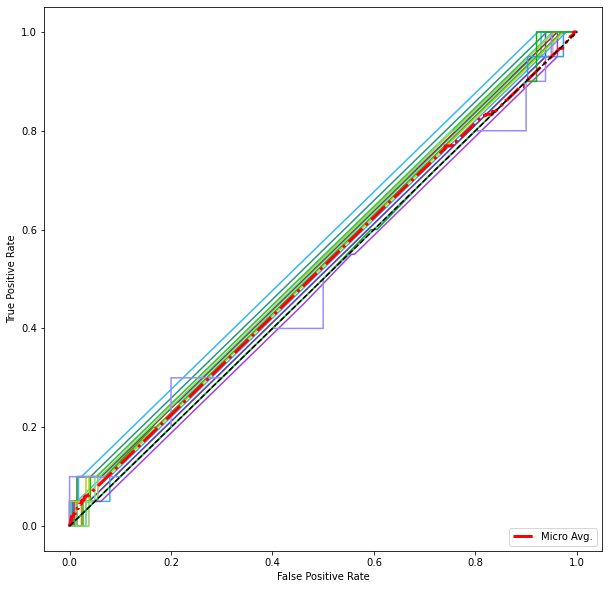

AUC score: 0.527


In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
auc_ann, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_ann, n_classes=len(individuals_test), ax=ax
)
fig.savefig("results_specs/ann/roc_ann.png")
print("AUC score: {:0.3f}".format(auc_ann))

Metrics

In [55]:
metr_ann, acc_ann,f1_ann = evaluate_performance.metrics(
    y=ytrues, yp=pred_ann,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_ann, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)
print("Macro avg. Accuracy: {:0.3f}".format(acc_ann))
metr_ann

C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn

Macro avg. Accuracy: 0.069


Label  Precision    Recall
0      VBBF083   0.078947  0.150000
1      VBBF088   0.333333  0.050000
2      VBBM071   0.000000  0.000000
3      VBBM090   0.055556  0.100000
4      VRRF180   0.055556  0.100000
5      VRRM181   0.250000  0.050000
6      VRRM182   0.073171  0.150000
7      VRRM183   0.051282  0.100000
8      VUKF016   0.060811  0.450000
9      VUKF018   0.000000  0.000000
10     VUKM004   0.222222  0.100000
11     VUKM017   0.000000  0.000000
12     VVHM089   0.000000  0.000000
13      VWM132   0.000000  0.000000
14     VZUF009   0.000000  0.000000
15     VZUF014   0.000000  0.000000
16     VZUM011   0.000000  0.000000
17     VZUM016   0.000000  0.000000
18  Macro Avg.   0.065604  0.069444

McNemar's test vs. Dummy

In [56]:
stat_ann, p_ann, tab_ann = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy,
    clf2_pred=pred_ann
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_ann, p_ann))

McNemar's test:
	statistic: 0.205
	p-value: 6.511e-01


In [57]:
# save metrics
d = {
    "acc": acc_ann,
    "auc": auc_ann,
    "f1": f1_ann,
    "mcc": mcc_ann,
    "kappa": kappa_ann,
    "table": metr_ann,
    "mcnemar": [stat_ann, p_ann]
}
with open("results_specs/ann/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)

## **Convolutional Neural Network (2D):**

In [8]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/")

In [9]:
%%capture
# cnn
pred_cnn = []
probs_cnn = []
ytrues = [] # list of true labels
times_cnn = []

## TODO: increase page-file size for 10 fold cv

for i in range(1):

    # load in batches the spectrograms
    X_train, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=train.iloc[idxs_train[i]], directory=None, created=True
    )
    X_test, _ = feature_extraction.spec_img(
        specs_dB = None, sample_rates=None, metadata_df=test.iloc[idxs_test[i]], directory=None, created=True
    )

    # training
    start = time.perf_counter()
    
    cnn = algorithms.CNN_2D(input_shape=X_train[0].shape, n_classes=len(train.Code.unique()), random_state=i+42)
    history_cnn = cnn.fit(
        X=X_train, y=feature_extraction.one_hot(y_train[idxs_train[i]]),
        batch_size=32, epochs=70
        )

    end = time.perf_counter()

    # evaluation
    tmp_pred, tmp_prob = cnn.predict(X=X_test)

    pred_cnn.append(tmp_pred)
    probs_cnn.append(tmp_prob)

    ytrues.append(y_test[idxs_test[i]])
    times_cnn.append(end-start)

# to arrays
pred_cnn = np.array(pred_cnn)
probs_cnn = np.array(probs_cnn)
ytrues = np.array(ytrues)

# reshaping
pred_cnn = np.reshape(pred_cnn, newshape=(pred_cnn.shape[1]*10))
probs_cnn = np.reshape(probs_cnn, 
    newshape=(probs_cnn.shape[1]*10, probs_cnn.shape[2]))
ytrues = np.reshape(ytrues, newshape=(ytrues.shape[1]*10))

ValueError: cannot reshape array of size 36 into shape (360,)

In [10]:
# to arrays
pred_cnn = np.array(pred_cnn)
probs_cnn = np.array(probs_cnn)
ytrues = np.array(ytrues)

In [16]:
# reshaping
pred_cnn = np.reshape(pred_cnn, newshape=(pred_cnn.shape[1]*1))
probs_cnn = np.reshape(probs_cnn, 
    newshape=(probs_cnn.shape[1]*1, probs_cnn.shape[2]))
ytrues = np.reshape(ytrues, newshape=(ytrues.shape[1]*1))

In [17]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis/code/general_identification/")

In [18]:
# save model
cnn.save("models/cnn/cnn_specs.h5")

In [19]:
# save variables
d = {
    "times": times_cnn,
    "pred": pred_cnn,  
    "probs": probs_cnn,
    "ytrues": ytrues,
    "individuals_test": individuals_test
}

with open("results_specs/cnn/vars.p", "wb") as fb:
    pickle.dump(d,  fb, protocol=pickle.HIGHEST_PROTOCOL)

### Convolutional Neural Network metrics

Confusion Matrix

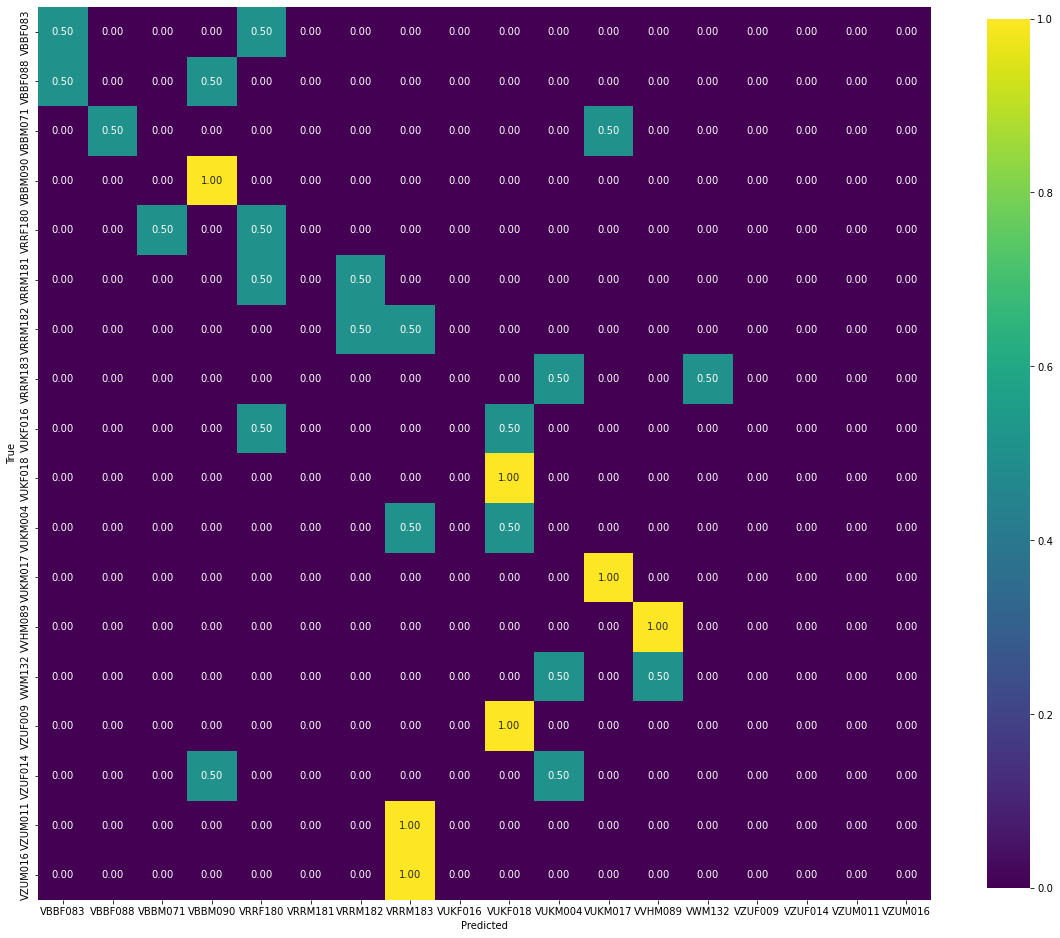

In [20]:
fig, ax = plt.subplots(1,1, figsize=(20,20))

cf_cnn, ax = evaluate_performance.conf_matrix(
    y=ytrues, yp=pred_cnn, labels=individuals_test, ax=ax
)
fig.savefig("results_specs/cnn/cf_cnn.png")

In [21]:
mcc_cnn = evaluate_performance.matthews(y=ytrues, yp=pred_cnn)
kappa_cnn = evaluate_performance.cohen(y=ytrues, yp=pred_cnn)

ROC curve and  AUC score

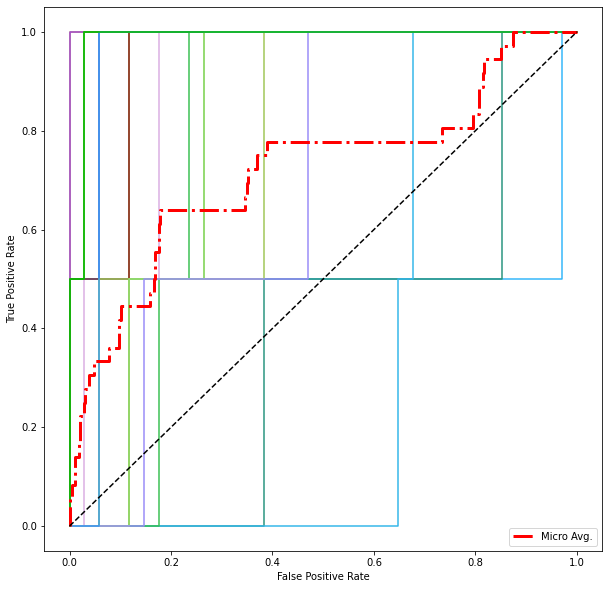

AUC score: 0.815


In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
auc_cnn, ax = evaluate_performance.roc_auc(
    y=ytrues, y_true=feature_extraction.one_hot(ytrues),
    y_score=probs_cnn, n_classes=len(individuals_test), ax=ax
)
fig.savefig("results_specs/cnn/roc_cnn.png")
print("AUC score: {:0.3f}".format(auc_cnn))

Metrics

In [24]:
metr_cnn, acc_cnn, f1_cnn = evaluate_performance.metrics(
    y=ytrues, yp=pred_cnn,
    y_true=feature_extraction.one_hot(ytrues),
    y_pred=feature_extraction.one_hot(pred_cnn, num_classes=len(np.unique(ytrues))),
    labels=individuals_test
)
print("Macro avg. Accuracy: {:0.3f}".format(acc_cnn))
metr_cnn

Macro avg. Accuracy: 0.306


C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alessandro\anaconda3\envs\thesis\lib\site-packages\sklearn

Label  Precision    Recall
0      VBBF083   0.500000  0.500000
1      VBBF088   0.000000  0.000000
2      VBBM071   0.000000  0.000000
3      VBBM090   0.500000  1.000000
4      VRRF180   0.250000  0.500000
5      VRRM181   0.000000  0.000000
6      VRRM182   0.500000  0.500000
7      VRRM183   0.000000  0.000000
8      VUKF016   0.000000  0.000000
9      VUKF018   0.333333  1.000000
10     VUKM004   0.000000  0.000000
11     VUKM017   0.666667  1.000000
12     VVHM089   0.666667  1.000000
13      VWM132   0.000000  0.000000
14     VZUF009   0.000000  0.000000
15     VZUF014   0.000000  0.000000
16     VZUM011   0.000000  0.000000
17     VZUM016   0.000000  0.000000
18  Macro Avg.   0.189815  0.305556

McNemar's test vs. Dummy

In [31]:
stat_cnn, p_cnn, tab_cnn = evaluate_performance.mcnemar_test(
    y_true=ytrues,
    clf1_pred=pred_dummy[0],
    clf2_pred=pred_cnn
)
print("McNemar's test:\n\tstatistic: {:0.3f}\n\tp-value: {:1.3e}".format(stat_cnn, p_cnn))

McNemar's test:
	statistic: 4.923
	p-value: 2.650e-02


In [32]:
# save metrics
d = {
    "acc": acc_cnn,
    "auc": auc_cnn,
    "f1": f1_cnn,
    "mcc": mcc_cnn,
    "kappa": kappa_cnn,
    "table": metr_cnn,
    "mcnemar": [stat_cnn, p_cnn]
}
with open("results_specs/cnn/metrics.p", "wb") as fb:
    pickle.dump(d, fb, protocol=pickle.HIGHEST_PROTOCOL)